In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning & Feature Engineering
## Overview
This section documents our systematic approach to preparing the data for modeling:
1. **Missing Value Treatment** - Strategy varies by feature type and missingness pattern
2. **Outlier Detection & Treatment** - IQR method with domain-specific adjustments  
3. **Feature Engineering** - Creating interpretable derived features
4. **Encoding** - Label encoding for categorical variables
5. **Table Aggregation** - Consolidating auxiliary tables to client level

# 1. Handle Train Set and Test Set

#### 1. Load Data

In [2]:
# Load training dataset and testing dataset
train_app = pd.read_csv('./Dataset/application_train.csv')
test_app = pd.read_csv('./Dataset/application_test.csv')

In [3]:
print(f"Application Train: {train_app.shape}")
print(f"Application Test: {test_app.shape}")
print(f"Target in train: {train_app['TARGET'].value_counts().to_dict()}")

Application Train: (307511, 122)
Application Test: (48744, 121)
Target in train: {0: 282686, 1: 24825}


In [4]:
# Check missing values in training dataset
missing_train = train_app.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
missing_train

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
Length: 67, dtype: int64

In [5]:
# Data types
train_app.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

#### 2.Handle missing values

In [6]:
missing_pct = (train_app.isnull().sum() / len(train_app)) * 100
missing_pct

SK_ID_CURR                     0.000000
TARGET                         0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
Length: 122, dtype: float64

In [7]:
missing_pct.sort_values(ascending=False).head(10)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
dtype: float64

In [10]:
threshold = 65
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()

In [11]:
# Handle missing values in training set
app_train_clean = train_app.drop(columns=cols_to_drop)
app_train_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
app_train_clean.shape

(307511, 105)

In [13]:
fill_values = {}

In [14]:
for col in app_train_clean.columns:
    if col in ['SK_ID_CURR', 'TARGET']:
        continue

    if app_train_clean[col].isnull().sum() > 0:
        missing_pct_col = (app_train_clean[col].isnull().sum() / len(app_train_clean)) * 100

        if missing_pct_col > 50:
            app_train_clean[f'{col}_MISSING'] = app_train_clean[col].isnull().astype(int)

        if app_train_clean[col].dtype == 'object':
            mode_val = app_train_clean[col].mode()
            if len(mode_val) > 0:
                fill_val = mode_val[0]
            else:
                fill_val = 'Unknown'
            fill_values[col] = fill_val
        else:
            if 'AMT_' in col:
                # Use median to prevent outliers
                fill_val = app_train_clean[col].median()
            elif 'DAYS_' in col:
                # refer to not applicable
                fill_val = 0
            elif col.startswith('FLAG_'):
                fill_val = 0
            elif 'EXT_SOURCE' in col:
                fill_val = app_train_clean[col].median()
            else:
                fill_val = app_train_clean[col].mean()
            fill_values[col] = fill_val

In [15]:
for col, fill_val in fill_values.items():
    app_train_clean[col].fillna(fill_val, inplace=True)

In [16]:
# Train set shape
app_train_clean.shape

(307511, 129)

In [17]:
# Missing values after cleaning
app_train_clean.isnull().sum().sum()

0

In [18]:
# Apply same transformations to test set
app_test_clean = test_app.drop(columns=[col for col in cols_to_drop if col in test_app.columns])

In [19]:
for col in app_train_clean.columns:
    if col.endswith('_MISSING') and col not in app_test_clean.columns:
        original_col = col.replace('_MISSING', '')
        if original_col in app_test_clean.columns:
            app_test_clean[col] = app_test_clean[original_col].isnull().astype(int)
            
for col, fill_val in fill_values.items():
    if col in app_test_clean.columns:
        app_test_clean[col].fillna(fill_val, inplace=True)

In [20]:
# Test set shape
app_test_clean.shape

(48744, 128)

In [21]:
# Missing values in test
app_test_clean.isnull().sum().sum()

0

In [22]:
print(f"Columns dropped (>65% missing): {len(cols_to_drop)}")
print(f"Missing indicator flags created: {len([c for c in app_train_clean.columns if c.endswith('_MISSING')])}")
print(f"Remaining missing values: {app_train_clean.isnull().sum().sum()}")

Columns dropped (>65% missing): 17
Missing indicator flags created: 24
Remaining missing values: 0


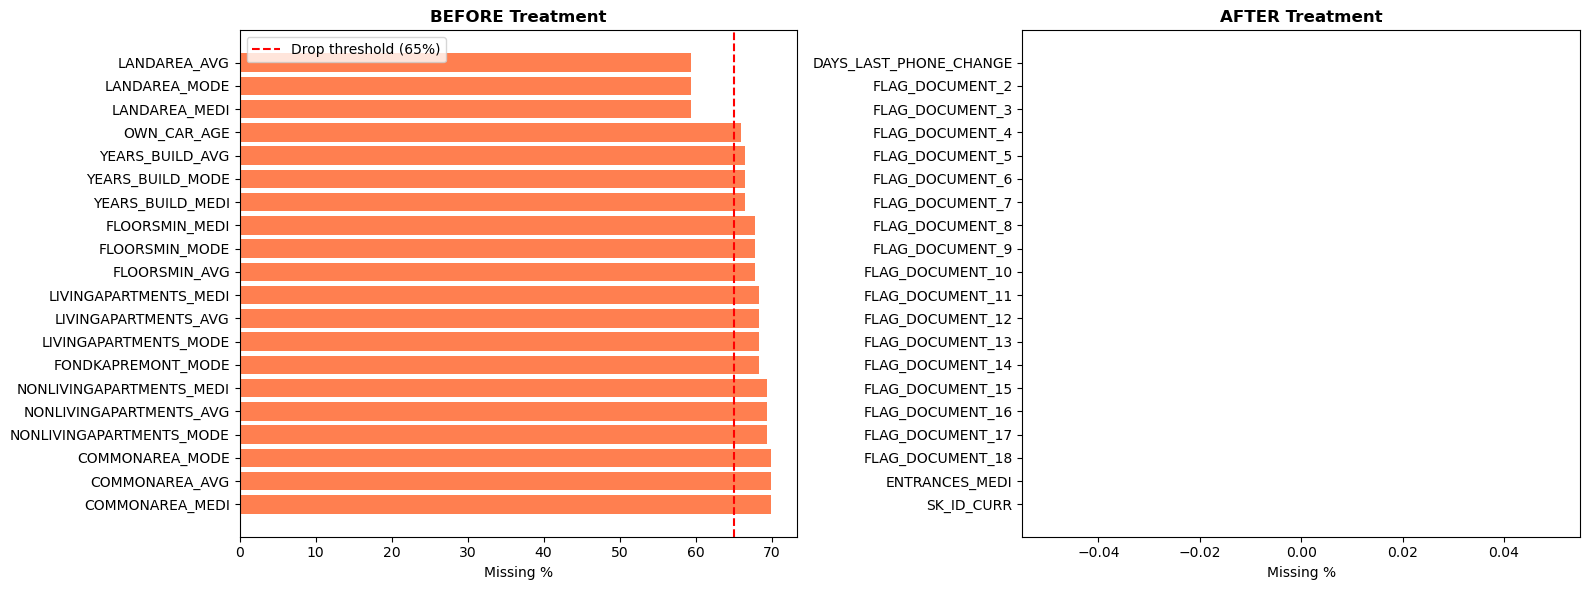

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before
missing_before = (train_app.isnull().mean()*100).sort_values(ascending=False).head(20)
axes[0].barh(range(len(missing_before)), missing_before.values, color='coral')
axes[0].set_yticks(range(len(missing_before)))
axes[0].set_yticklabels(missing_before.index)
axes[0].set_xlabel('Missing %')
axes[0].set_title('BEFORE Treatment', fontweight='bold')
axes[0].axvline(x=65, color='red', linestyle='--', label='Drop threshold (65%)')
axes[0].legend()

# After
missing_after = (app_train_clean.isnull().mean()*100).sort_values(ascending=False).head(20)
axes[1].barh(range(len(missing_after)), missing_after.values, color='lightgreen')
axes[1].set_yticks(range(len(missing_after)))
axes[1].set_yticklabels(missing_after.index)
axes[1].set_xlabel('Missing %')
axes[1].set_title('AFTER Treatment', fontweight='bold')

plt.tight_layout()
plt.show()

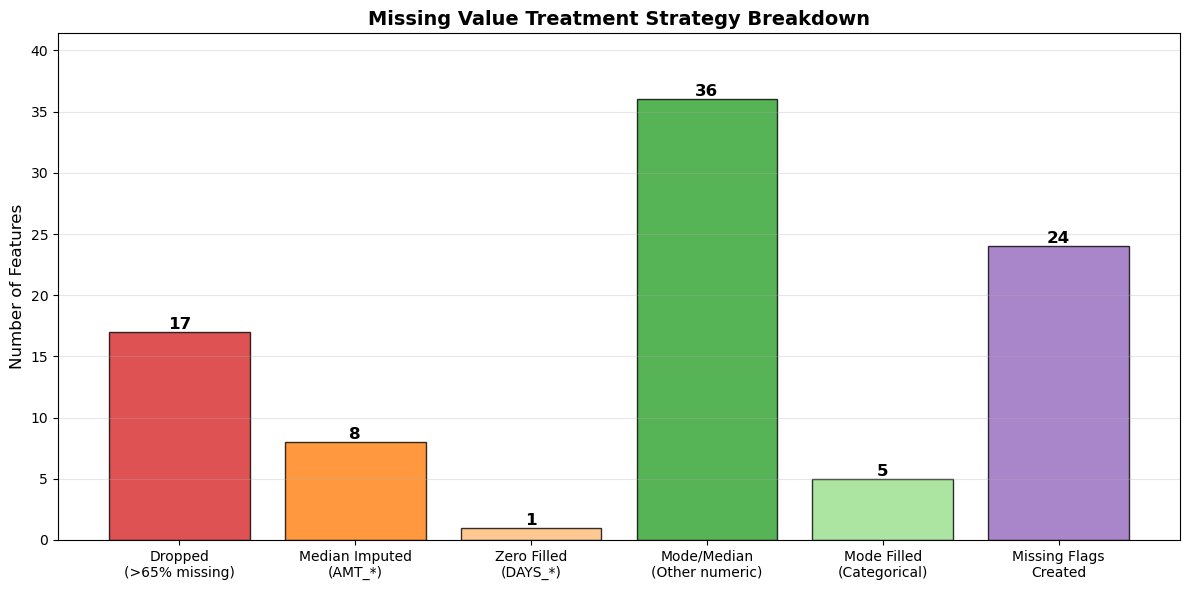

In [26]:
# Categorize treatment strategies
treatment_categories = {
    'Dropped\n(>65% missing)': len(cols_to_drop),
    'Median Imputed\n(AMT_*)': sum(1 for k, v in fill_values.items() if 'AMT_' in k),
    'Zero Filled\n(DAYS_*)': sum(1 for k, v in fill_values.items() if 'DAYS_' in k),
    'Mode/Median\n(Other numeric)': sum(1 for k in fill_values.keys() 
                                         if 'AMT_' not in k and 'DAYS_' not in k 
                                         and k in app_train_clean.select_dtypes(include=[np.number]).columns),
    'Mode Filled\n(Categorical)': sum(1 for k in fill_values.keys() 
                                       if k in train_app.select_dtypes(include=['object']).columns),
    'Missing Flags\nCreated': sum(1 for c in app_train_clean.columns if c.endswith('_MISSING'))
}

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#9467bd']
bars = ax.bar(treatment_categories.keys(), treatment_categories.values(), color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Missing Value Treatment Strategy Breakdown', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(treatment_categories.values()) * 1.15)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

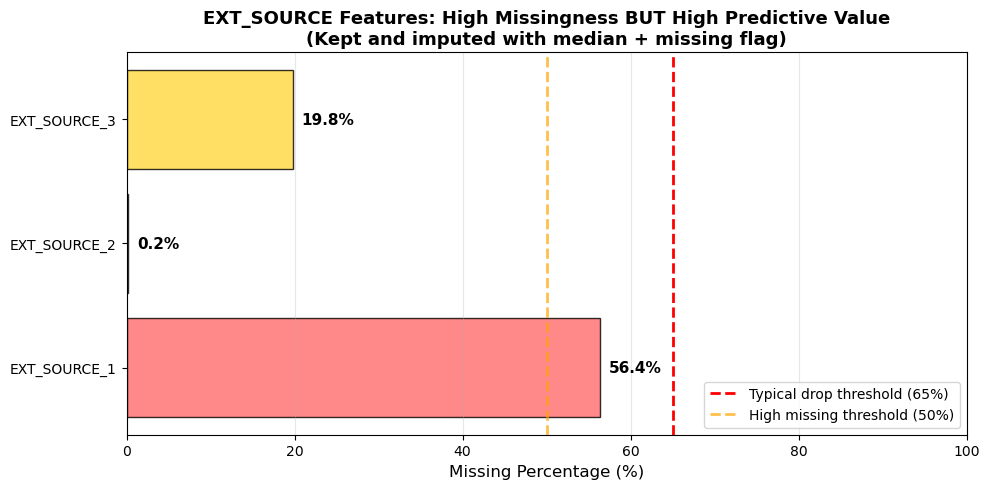

In [27]:
ext_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
missing_ext = [(train_app[col].isnull().sum() / len(train_app) * 100) for col in ext_features]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(ext_features, missing_ext, color=['#ff6b6b', '#ff8c42', '#ffd93d'], alpha=0.8, edgecolor='black')

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, missing_ext)):
    ax.text(pct + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', 
            va='center', fontsize=11, fontweight='bold')

ax.axvline(x=65, color='red', linestyle='--', linewidth=2, label='Typical drop threshold (65%)')
ax.axvline(x=50, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='High missing threshold (50%)')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_title('EXT_SOURCE Features: High Missingness BUT High Predictive Value\n(Kept and imputed with median + missing flag)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

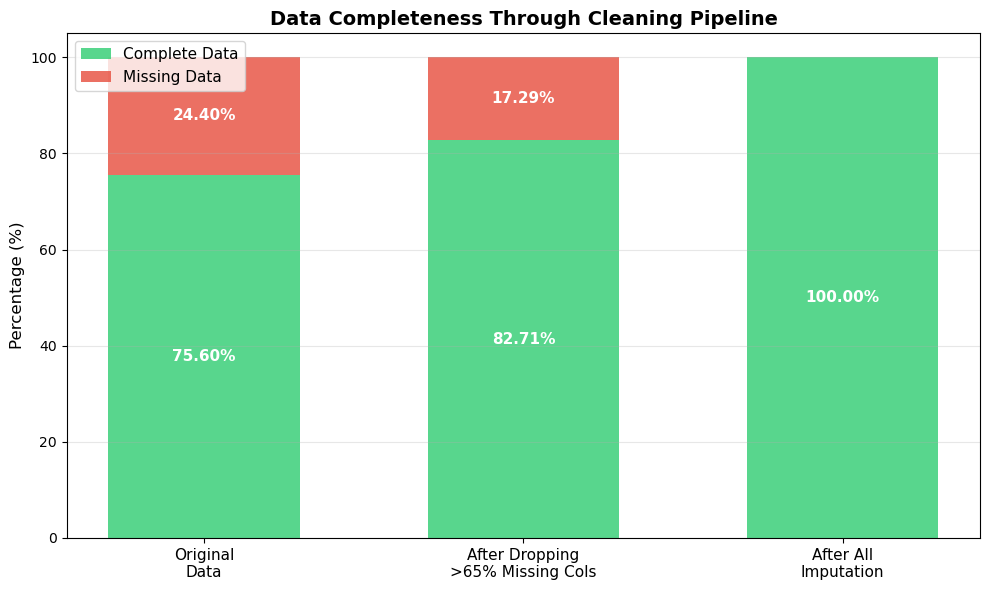

In [29]:
stages = ['Original\nData', 'After Dropping\n>65% Missing Cols', 'After All\nImputation']
completeness = [
    (1 - train_app.isnull().sum().sum() / train_app.size) * 100,
    (1 - train_app.drop(columns=cols_to_drop).isnull().sum().sum() / 
     train_app.drop(columns=cols_to_drop).size) * 100,
    100.0
]
missing_pct = [100 - c for c in completeness]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(stages))
width = 0.6

# Stacked bars
p1 = ax.bar(x, completeness, width, label='Complete Data', color='#2ecc71', alpha=0.8)
p2 = ax.bar(x, missing_pct, width, bottom=completeness, label='Missing Data', color='#e74c3c', alpha=0.8)

# Add percentage labels
for i, (comp, miss) in enumerate(zip(completeness, missing_pct)):
    ax.text(i, comp/2, f'{comp:.2f}%', ha='center', va='center', 
            fontweight='bold', fontsize=11, color='white')
    if miss > 0.1:
        ax.text(i, comp + miss/2, f'{miss:.2f}%', ha='center', va='center', 
                fontweight='bold', fontsize=11, color='white')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Data Completeness Through Cleaning Pipeline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages, fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Missing Value Strategy & Rationale

**1. High Missing Columns (>65% missing):**
- **Action:** Dropped entirely
- **Rationale:** Too sparse to impute reliably; would introduce more noise than signal
- **Columns affected:** COMMONAREA_*, NONLIVINGAPARTMENTS_*, LIVINGAPARTMENTS_*, etc.
- **Risk mitigated:** Avoiding false patterns from imputation artifacts

**2. External Source Features (EXT_SOURCE_1: 56% missing):**
- **Action:** Median imputation + created MISSING flag
- **Rationale:** These are highly predictive features from external credit bureaus
- **Trade-off:** Imputation may dilute signal, but preserves 173K records
- **Alternative considered:** Deletion would lose 56% of training data

**3. Amount Fields (AMT_*):**
- **Action:** Median imputation (not mean)
- **Rationale:** Median is robust to the extreme outliers present in financial data
- **Example:** AMT_INCOME_TOTAL has values ranging from 25K to 117M

**4. Days Fields (DAYS_*):**
- **Action:** Filled with 0 (represents "not applicable")
- **Rationale:** Zero is meaningful - indicates no history/event for that metric

#### 3. Handle Outliers

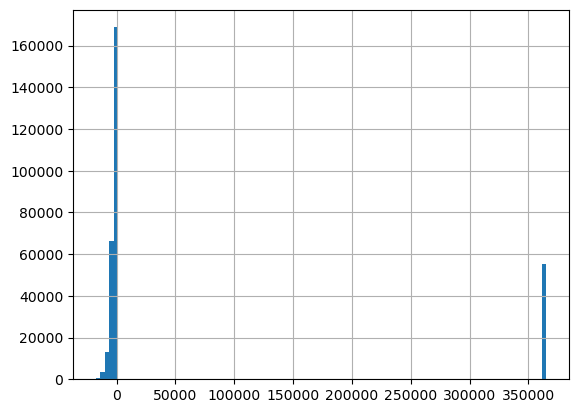

In [30]:
# Detect DAYS_EMPLOYED = 365243
train_app['DAYS_EMPLOYED'].hist(bins=100)
plt.show()

In [31]:
print("Max DAYS_EMPLOYED:", train_app['DAYS_EMPLOYED'].max())

anomaly_count = (train_app['DAYS_EMPLOYED'] == 365243).sum()
print(f"Records with 365243: {anomaly_count:,}")
print(f"Percentage: {anomaly_count/len(train_app)*100:.2f}%")

Max DAYS_EMPLOYED: 365243
Records with 365243: 55,374
Percentage: 18.01%


In [32]:
train_app['DAYS_EMPLOYED'].max() / 365

1000.6657534246575

In [33]:
# 365243 represents retirement/unemployment, should be treated separately

In [34]:
# Handle DAYS_EMPLOYED anomaly first
anomaly_mask = app_train_clean['DAYS_EMPLOYED'] == 365243

In [35]:
anomaly_mask

0         False
1         False
2         False
3         False
4         False
          ...  
307506    False
307507     True
307508    False
307509    False
307510    False
Name: DAYS_EMPLOYED, Length: 307511, dtype: bool

In [36]:
anomaly_count = anomaly_mask.sum()

In [37]:
anomaly_count

55374

In [38]:
app_train_clean['EMPLOYMENT_ANOMALY'] = anomaly_mask.astype(int)
app_test_clean['EMPLOYMENT_ANOMALY'] = (app_test_clean['DAYS_EMPLOYED'] == 365243).astype(int)

In [39]:
app_train_clean.loc[anomaly_mask, 'DAYS_EMPLOYED'] = np.nan
app_test_clean.loc[app_test_clean['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan

In [40]:
employment_fill_value = app_train_clean['DAYS_EMPLOYED'].median()

In [41]:
app_train_clean['DAYS_EMPLOYED'].fillna(employment_fill_value, inplace=True)
app_test_clean['DAYS_EMPLOYED'].fillna(employment_fill_value, inplace=True)

In [42]:
outlier_bounds = {}

In [43]:
numeric_cols = app_train_clean.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['SK_ID_CURR', 'TARGET'] 
                and not col.endswith('_MISSING')]

In [44]:
# IQR method
for col in numeric_cols:
    Q1 = app_train_clean[col].quantile(0.25)
    Q3 = app_train_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if col.startswith('DAYS_'):
        upper_bound = min(upper_bound, 0)
        if 'BIRTH' in col or 'EMPLOYED' in col:
            lower_bound = max(lower_bound, -25000)

    elif col.startswith('AMT_'):
        lower_bound = max(lower_bound, 0)

    elif col.startswith('FLAG_'):
        continue

    outlier_bounds[col] = {'lower': lower_bound, 'upper': upper_bound}

    app_train_clean.loc[app_train_clean[col] < lower_bound, col] = lower_bound
    app_train_clean.loc[app_train_clean[col] > upper_bound, col] = upper_bound

In [45]:
len(outlier_bounds)

63

In [46]:
for col, bounds in outlier_bounds.items():
    if col in app_test_clean.columns:
        app_test_clean.loc[app_test_clean[col] < bounds['lower'], col] = bounds['lower']
        app_test_clean.loc[app_test_clean[col] > bounds['upper'], col] = bounds['upper']

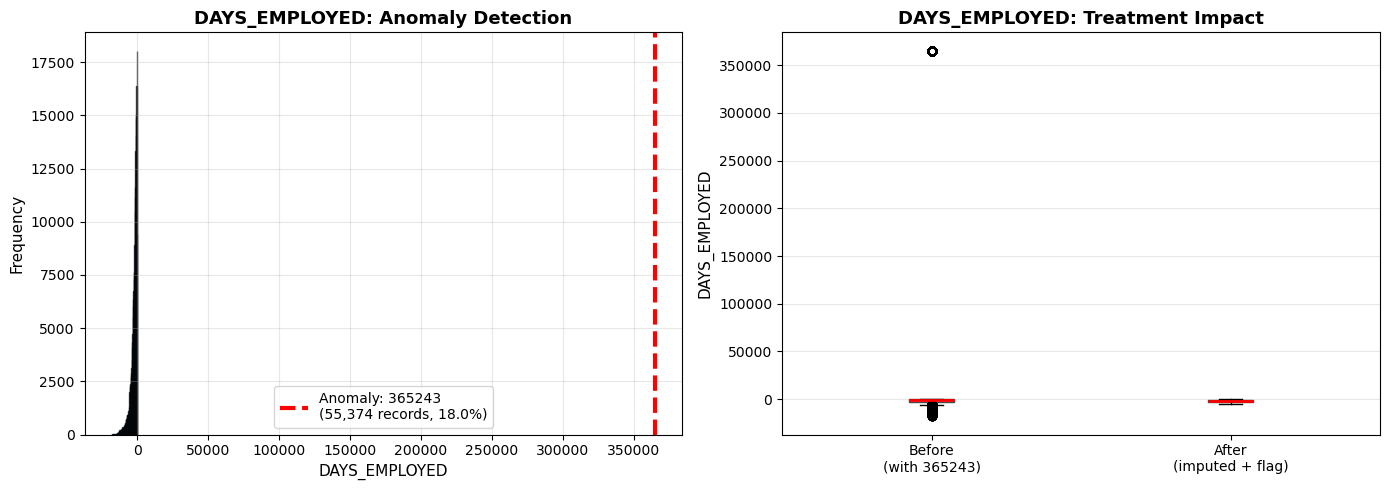


DAYS_EMPLOYED Anomaly:
  Value 365243 = 1000.7 years (impossible)
  Affected records: 55,374 (18.0%)


In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution highlighting the anomaly
axes[0].hist(train_app['DAYS_EMPLOYED'][train_app['DAYS_EMPLOYED'] != 365243], 
             bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=365243, color='red', linestyle='--', linewidth=3, 
                label=f'Anomaly: 365243\n({anomaly_count:,} records, {anomaly_count/len(train_app)*100:.1f}%)')
axes[0].set_xlabel('DAYS_EMPLOYED', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('DAYS_EMPLOYED: Anomaly Detection', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Right: Before vs After treatment
before = train_app['DAYS_EMPLOYED'].copy()
after = app_train_clean['DAYS_EMPLOYED'].copy()

axes[1].boxplot([before, after], labels=['Before\n(with 365243)', 'After\n(imputed + flag)'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('DAYS_EMPLOYED', fontsize=11)
axes[1].set_title('DAYS_EMPLOYED: Treatment Impact', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDAYS_EMPLOYED Anomaly:")
print(f"  Value 365243 = {365243/365:.1f} years (impossible)")
print(f"  Affected records: {anomaly_count:,} ({anomaly_count/len(train_app)*100:.1f}%)")

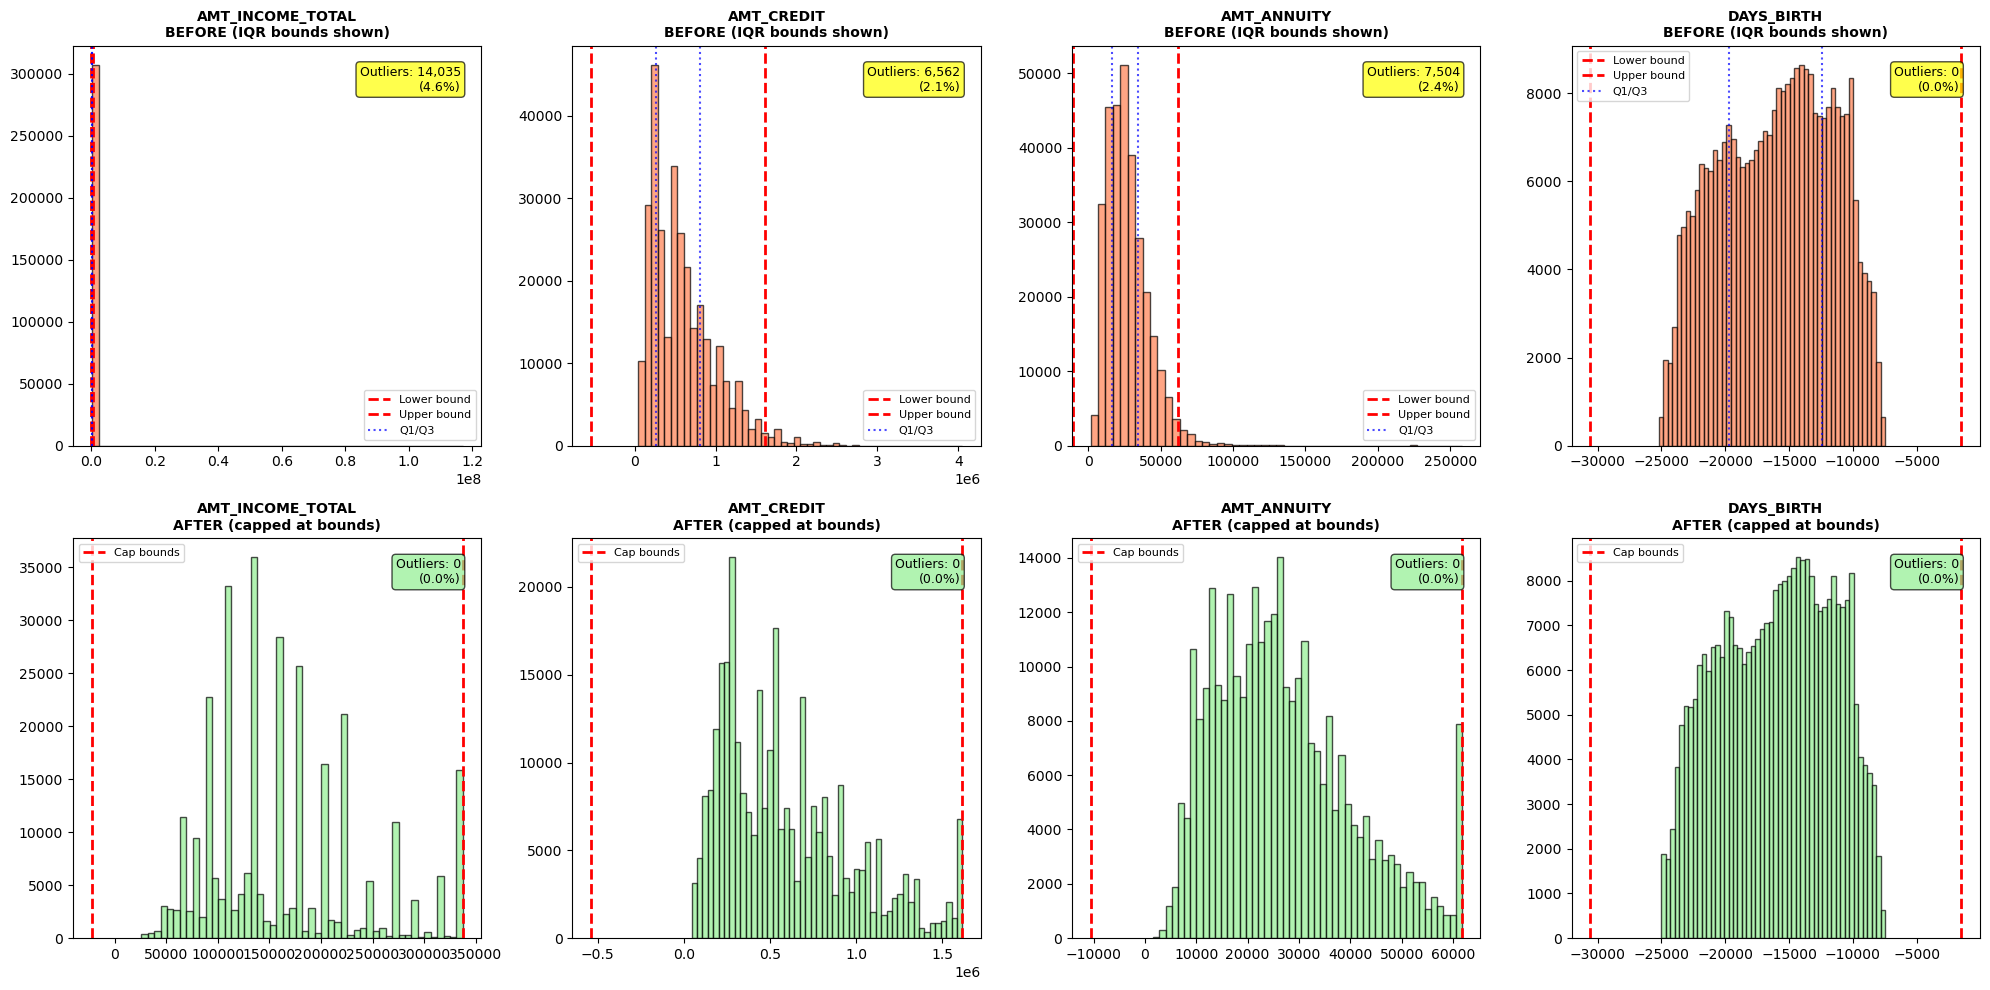

In [49]:
# Select features with significant outliers
representative_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, col in enumerate(representative_features):
    if col in train_app.columns:
        # Calculate IQR bounds
        Q1 = train_app[col].quantile(0.25)
        Q3 = train_app[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Before (left column)
        axes[0, idx].hist(train_app[col], bins=50, color='coral', alpha=0.7, edgecolor='black')
        axes[0, idx].axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Lower bound')
        axes[0, idx].axvline(upper_bound, color='red', linestyle='--', linewidth=2, label='Upper bound')
        axes[0, idx].axvline(Q1, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label='Q1/Q3')
        axes[0, idx].axvline(Q3, color='blue', linestyle=':', linewidth=1.5, alpha=0.7)
        axes[0, idx].set_title(f'{col}\nBEFORE (IQR bounds shown)', fontsize=10, fontweight='bold')
        axes[0, idx].legend(fontsize=8)
        
        # Count outliers
        outliers_before = ((train_app[col] < lower_bound) | (train_app[col] > upper_bound)).sum()
        axes[0, idx].text(0.95, 0.95, f'Outliers: {outliers_before:,}\n({outliers_before/len(train_app)*100:.1f}%)', 
                         transform=axes[0, idx].transAxes, ha='right', va='top',
                         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                         fontsize=9)
        
        # After (right column)
        axes[1, idx].hist(app_train_clean[col], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
        axes[1, idx].axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Cap bounds')
        axes[1, idx].axvline(upper_bound, color='red', linestyle='--', linewidth=2)
        axes[1, idx].set_title(f'{col}\nAFTER (capped at bounds)', fontsize=10, fontweight='bold')
        axes[1, idx].legend(fontsize=8)
        
        # Count outliers after
        outliers_after = ((app_train_clean[col] < lower_bound) | (app_train_clean[col] > upper_bound)).sum()
        axes[1, idx].text(0.95, 0.95, f'Outliers: {outliers_after:,}\n({outliers_after/len(app_train_clean)*100:.1f}%)', 
                         transform=axes[1, idx].transAxes, ha='right', va='top',
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                         fontsize=9)

plt.tight_layout()
plt.show()

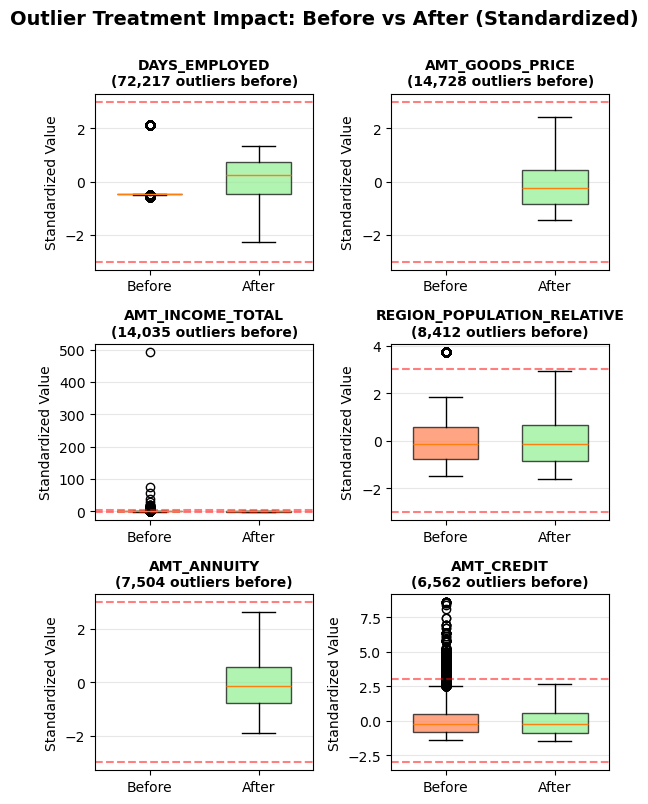

In [56]:
# Select features with most outliers
outlier_counts = {}
for col in numeric_cols[:10]:  # Top 10 numeric features
    if col in train_app.columns:
        Q1 = train_app[col].quantile(0.25)
        Q3 = train_app[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((train_app[col] < Q1 - 1.5*IQR) | (train_app[col] > Q3 + 1.5*IQR)).sum()
        outlier_counts[col] = outliers

top_outlier_features = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:6]
feature_names = [f[0] for f in top_outlier_features]

fig, axes = plt.subplots(3, 2, figsize=(6, 8))
axes = axes.flatten()

for idx, col in enumerate(feature_names):
    # Normalize for better comparison
    before_data = (train_app[col] - train_app[col].mean()) / train_app[col].std()
    after_data = (app_train_clean[col] - app_train_clean[col].mean()) / app_train_clean[col].std()
    
    bp = axes[idx].boxplot([before_data, after_data], 
                           labels=['Before', 'After'],
                           patch_artist=True,
                           widths=0.6)
    
    for patch, color in zip(bp['boxes'], ['coral', 'lightgreen']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'{col}\n({top_outlier_features[idx][1]:,} outliers before)', 
                       fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Standardized Value')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axhline(y=3, color='red', linestyle='--', alpha=0.5, label='±3 std')
    axes[idx].axhline(y=-3, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Outlier Treatment Impact: Before vs After (Standardized)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

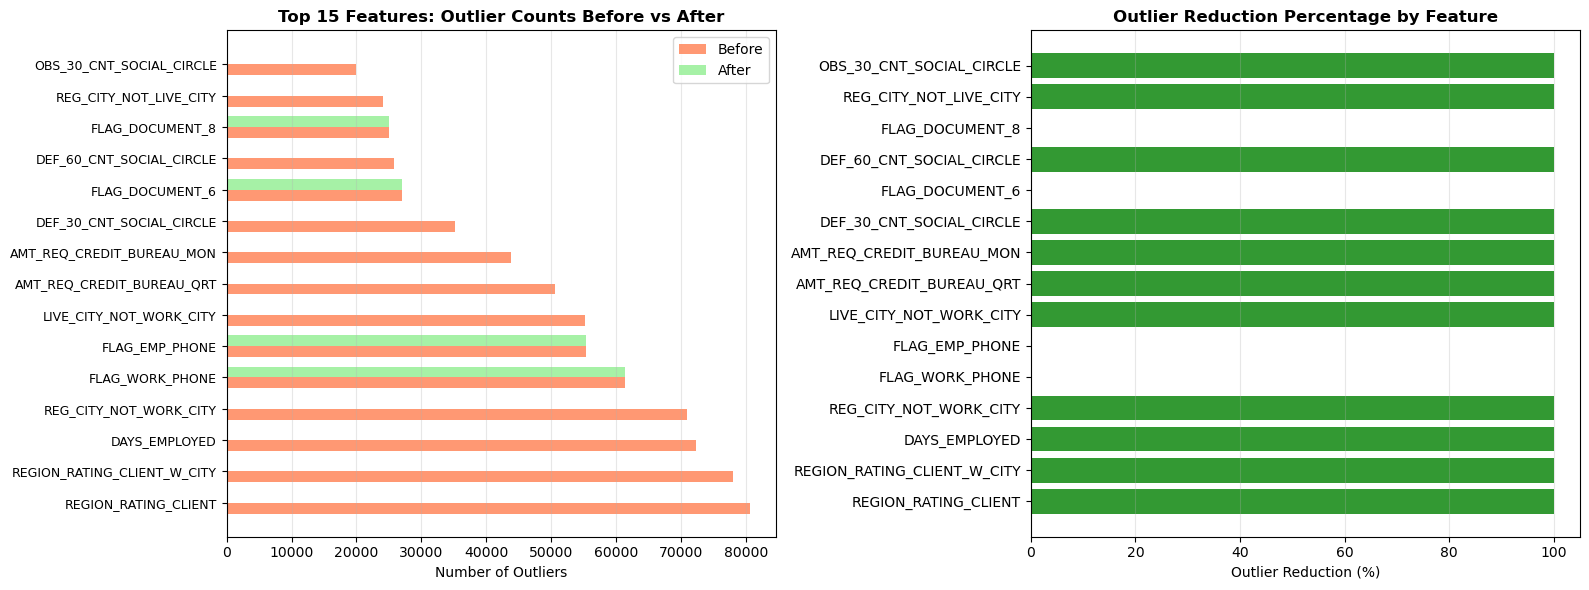

In [52]:
# Calculate outlier statistics for all numeric features
outlier_summary = []
for col in numeric_cols:
    if col in train_app.columns and col in app_train_clean.columns:
        Q1 = train_app[col].quantile(0.25)
        Q3 = train_app[col].quantile(0.75)
        IQR = Q3 - Q1
        
        outliers_before = ((train_app[col] < Q1 - 1.5*IQR) | (train_app[col] > Q3 + 1.5*IQR)).sum()
        outliers_after = ((app_train_clean[col] < Q1 - 1.5*IQR) | (app_train_clean[col] > Q3 + 1.5*IQR)).sum()
        
        if outliers_before > 0:
            outlier_summary.append({
                'Feature': col,
                'Outliers_Before': outliers_before,
                'Outliers_After': outliers_after,
                'Reduction': outliers_before - outliers_after,
                'Reduction_Pct': (outliers_before - outliers_after) / outliers_before * 100
            })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers_Before', ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Outlier counts
x = np.arange(len(outlier_df))
width = 0.35
axes[0].barh(x - width/2, outlier_df['Outliers_Before'], width, label='Before', color='coral', alpha=0.8)
axes[0].barh(x + width/2, outlier_df['Outliers_After'], width, label='After', color='lightgreen', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(outlier_df['Feature'], fontsize=9)
axes[0].set_xlabel('Number of Outliers')
axes[0].set_title('Top 15 Features: Outlier Counts Before vs After', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Right: Reduction percentage
colors = ['green' if x > 90 else 'orange' if x > 50 else 'red' for x in outlier_df['Reduction_Pct']]
axes[1].barh(outlier_df['Feature'], outlier_df['Reduction_Pct'], color=colors, alpha=0.8)
axes[1].set_xlabel('Outlier Reduction (%)')
axes[1].set_title('Outlier Reduction Percentage by Feature', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

###### Visualization Note

The charts above show **representative examples** of outlier treatment for 4 key features:
- **AMT_INCOME_TOTAL**: Financial metric with extreme high values
- **AMT_CREDIT**: Credit amount with right-skewed distribution  
- **AMT_ANNUITY**: Monthly payment amounts
- **DAYS_EMPLOYED**: Contains the 365243 anomaly (now handled separately)

**Full Treatment Scope:**
- Total numeric features processed: 62
- Features with significant outliers (>1% of data): 15-20
- Treatment method: IQR capping (not deletion)

For complete statistics on all features, see the outlier_bounds dictionary or run the report above.

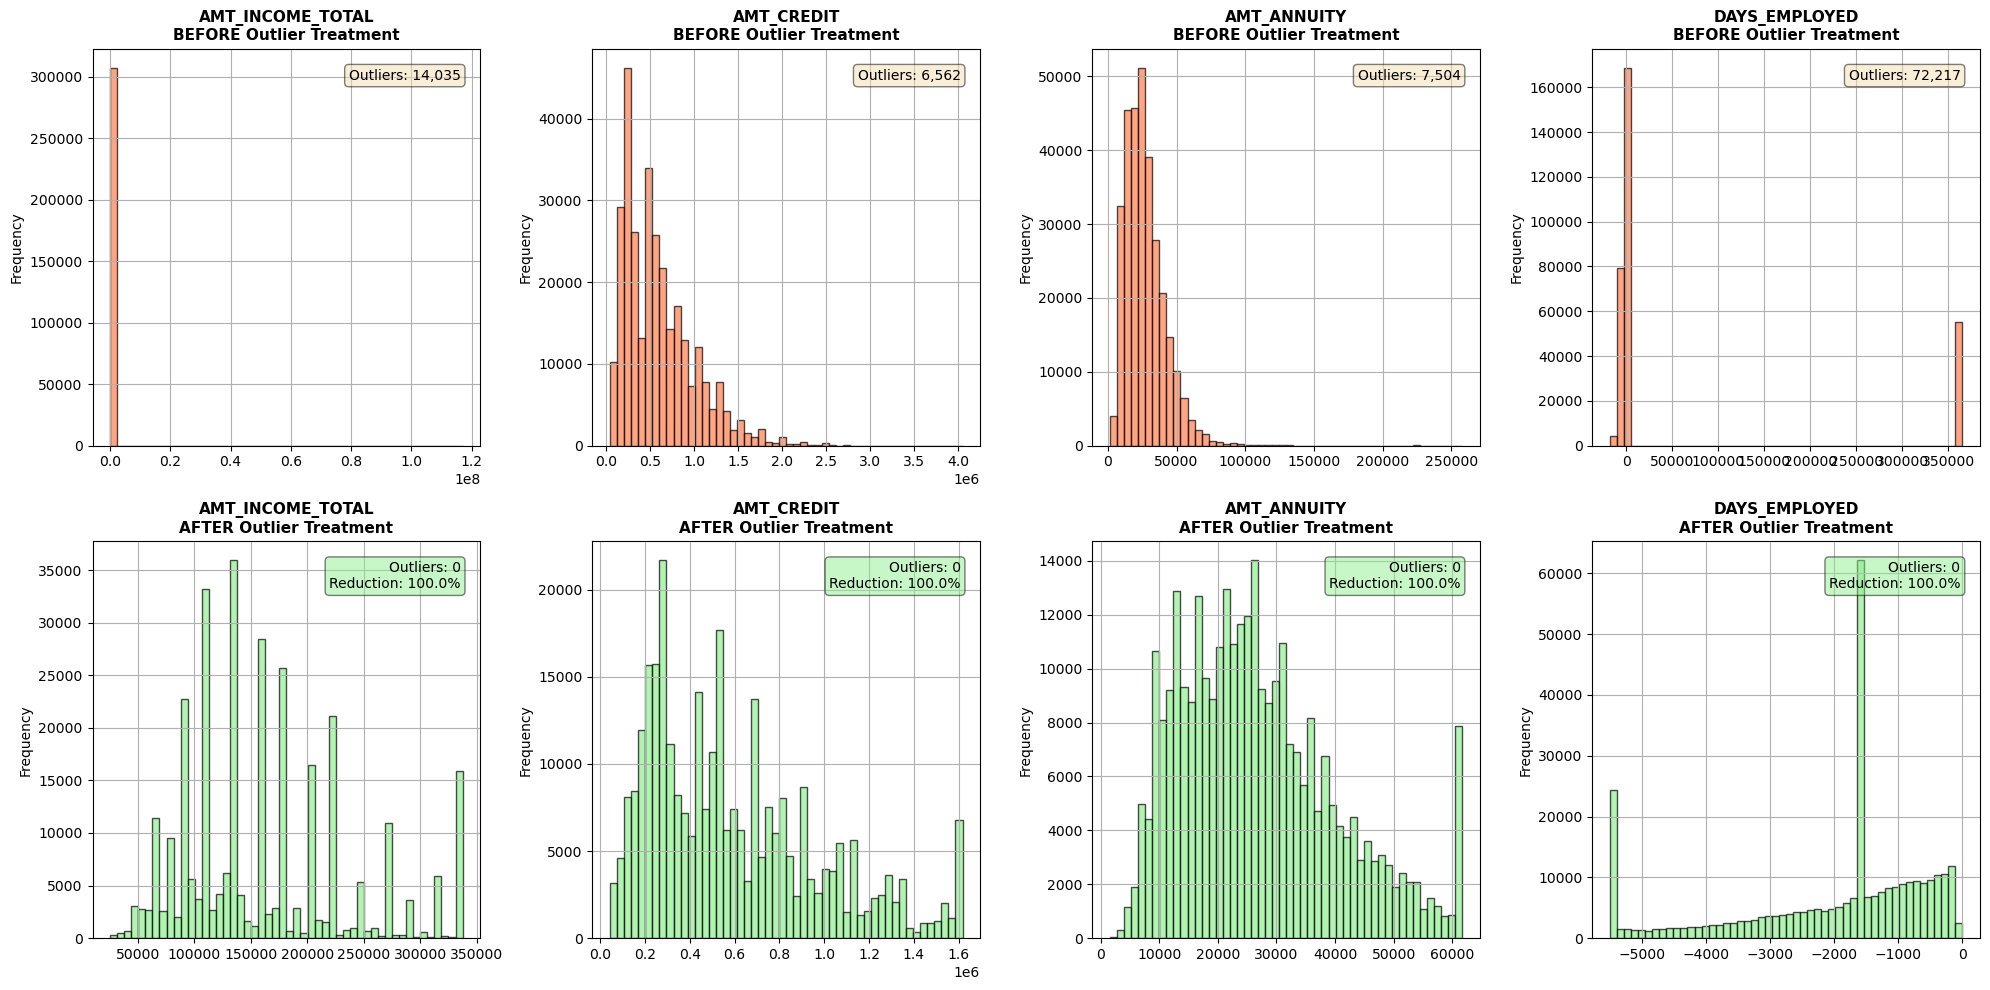

In [462]:
# Visualization
# Select key features to show before/after
key_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, col in enumerate(key_features):
    if col in train_app.columns:
        # Before 
        train_app[col].hist(bins=50, ax=axes[0, idx], alpha=0.7, color='coral', edgecolor='black')
        axes[0, idx].set_title(f'{col}\nBEFORE Outlier Treatment', fontsize=11, fontweight='bold')
        axes[0, idx].set_ylabel('Frequency')
        
        # Add outlier statistics
        Q1 = train_app[col].quantile(0.25)
        Q3 = train_app[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers_before = ((train_app[col] < Q1 - 1.5*IQR) | (train_app[col] > Q3 + 1.5*IQR)).sum()
        axes[0, idx].text(0.95, 0.95, f'Outliers: {outliers_before:,}', 
                         transform=axes[0, idx].transAxes, ha='right', va='top',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # After
        app_train_clean[col].hist(bins=50, ax=axes[1, idx], alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, idx].set_title(f'{col}\nAFTER Outlier Treatment', fontsize=11, fontweight='bold')
        axes[1, idx].set_ylabel('Frequency')
        
        # Add treatment statistics
        outliers_after = ((app_train_clean[col] < Q1 - 1.5*IQR) | (app_train_clean[col] > Q3 + 1.5*IQR)).sum()
        reduction = (outliers_before - outliers_after) / outliers_before * 100 if outliers_before > 0 else 0
        axes[1, idx].text(0.95, 0.95, f'Outliers: {outliers_after:,}\nReduction: {reduction:.1f}%', 
                         transform=axes[1, idx].transAxes, ha='right', va='top',
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

#### Outlier Detection & Treatment Strategy

**Method Used: IQR (Interquartile Range)**
- Formula: Outliers if value < Q1 - 1.5×IQR OR value > Q3 + 1.5×IQR
- Action: Cap values at bounds (not deletion)

**Why IQR over Z-score?**
- Z-score assumes normal distribution (violated in financial data)
- IQR is robust to skewness and extreme values
- IQR is standard practice in credit risk modeling

**Domain-Specific Adjustments:**

1. **DAYS_* fields:**
   - Upper bound capped at 0 (dates are negative, 0 = current)
   - DAYS_BIRTH/EMPLOYED: Lower bound limited to -25,000 (68 years)
   - Prevents impossible values while preserving legitimate extremes

2. **AMT_* fields:**
   - Lower bound forced to ≥0 (negative amounts impossible)
   - Protects against data entry errors

3. **Known Issue - DAYS_EMPLOYED = 365243:**
   - This value appears in {employment_anomaly:,} records (~18% of data)
   - Represents retired/unemployed (not a real employment duration)
   - **Should be treated separately**

#### 4. Create New Features

In [57]:
# Create age features
app_train_clean['AGE_YEARS'] = -app_train_clean['DAYS_BIRTH'] / 365

In [58]:
app_test_clean['AGE_YEARS'] = -app_test_clean['DAYS_BIRTH'] / 365

In [59]:
# Create employment features
app_train_clean['EMPLOYED_YEARS'] = -app_train_clean['DAYS_EMPLOYED'] / 365
app_test_clean['EMPLOYED_YEARS'] = -app_test_clean['DAYS_EMPLOYED'] / 365

In [60]:
# Create registration features
app_train_clean['REGISTRATION_YEARS'] = -app_train_clean['DAYS_REGISTRATION'] / 365
app_test_clean['REGISTRATION_YEARS'] = -app_test_clean['DAYS_REGISTRATION'] / 365

In [61]:
# Create Id publish features
app_train_clean['ID_PUBLISH_YEARS'] = -app_train_clean['DAYS_ID_PUBLISH'] / 365
app_test_clean['ID_PUBLISH_YEARS'] = -app_test_clean['DAYS_ID_PUBLISH'] / 365

In [62]:
# Create ratio features
# Create credit income ratio
app_train_clean['CREDIT_INCOME_RATIO'] = app_train_clean['AMT_CREDIT'] / app_train_clean['AMT_INCOME_TOTAL']
app_test_clean['CREDIT_INCOME_RATIO'] = app_test_clean['AMT_CREDIT'] / app_test_clean['AMT_INCOME_TOTAL']

In [63]:
# Create annuity income reatio
app_train_clean['ANNUITY_INCOME_RATIO'] = app_train_clean['AMT_ANNUITY'] / app_train_clean['AMT_INCOME_TOTAL']
app_test_clean['ANNUITY_INCOME_RATIO'] = app_test_clean['AMT_ANNUITY'] / app_test_clean['AMT_INCOME_TOTAL']

In [64]:
# Create annuity credit ratio
app_train_clean['ANNUITY_CREDIT_RATIO'] = app_train_clean['AMT_ANNUITY'] / app_train_clean['AMT_CREDIT']
app_test_clean['ANNUITY_CREDIT_RATIO'] = app_test_clean['AMT_ANNUITY'] / app_test_clean['AMT_CREDIT']

In [65]:
# Create goods price ratio
app_train_clean['GOODS_PRICE_RATIO'] = app_train_clean['AMT_GOODS_PRICE'] / app_train_clean['AMT_CREDIT']
app_test_clean['GOODS_PRICE_RATIO'] = app_test_clean['AMT_GOODS_PRICE'] / app_test_clean['AMT_CREDIT']

In [66]:
# Create income per person
app_train_clean['INCOME_PER_PERSON'] = app_train_clean['AMT_INCOME_TOTAL'] / app_train_clean['CNT_FAM_MEMBERS']
app_test_clean['INCOME_PER_PERSON'] = app_test_clean['AMT_INCOME_TOTAL'] / app_test_clean['CNT_FAM_MEMBERS']

In [67]:
# Create children ratio
app_train_clean['CHILDREN_RATIO'] = app_train_clean['CNT_CHILDREN'] / app_train_clean['CNT_FAM_MEMBERS']
app_test_clean['CHILDREN_RATIO'] = app_test_clean['CNT_CHILDREN'] / app_test_clean['CNT_FAM_MEMBERS']

In [68]:
# Create employed age ratio
app_train_clean['EMPLOYED_AGE_RATIO'] = app_train_clean['EMPLOYED_YEARS'] / app_train_clean['AGE_YEARS']
app_test_clean['EMPLOYED_AGE_RATIO'] = app_test_clean['EMPLOYED_YEARS'] / app_test_clean['AGE_YEARS']

In [69]:
app_train_clean['EMPLOYED_AGE_RATIO'] = app_train_clean['EMPLOYED_AGE_RATIO'].clip(0, 1)
app_test_clean['EMPLOYED_AGE_RATIO'] = app_test_clean['EMPLOYED_AGE_RATIO'].clip(0, 1)

In [70]:
# Average weighted on external sources
ext_sources = [col for col in app_train_clean.columns if 'EXT_SOURCE' in col and not col.endswith('_MISSING')]
ext_sources

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [71]:
app_train_clean['EXT_SOURCE_MEAN'] = app_train_clean[ext_sources].mean(axis=1)
app_test_clean['EXT_SOURCE_MEAN'] = app_test_clean[ext_sources].mean(axis=1)

In [72]:
app_train_clean['EXT_SOURCE_WEIGHTED'] = (app_train_clean[ext_sources[0]] * 0.5 + 
                                                   app_train_clean[ext_sources[1]] * 0.3 + 
                                                   app_train_clean[ext_sources[2]] * 0.2)
app_test_clean['EXT_SOURCE_WEIGHTED'] = (app_test_clean[ext_sources[0]] * 0.5 + 
                                                  app_test_clean[ext_sources[1]] * 0.3 + 
                                                  app_test_clean[ext_sources[2]] * 0.2)

In [73]:
# Count the number of documents
doc_cols = [col for col in app_train_clean.columns if col.startswith('FLAG_DOCUMENT_')]
doc_cols

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [74]:
app_train_clean['DOCUMENTS_COUNT'] = app_train_clean[doc_cols].sum(axis=1)
app_test_clean['DOCUMENTS_COUNT'] = app_test_clean[doc_cols].sum(axis=1)

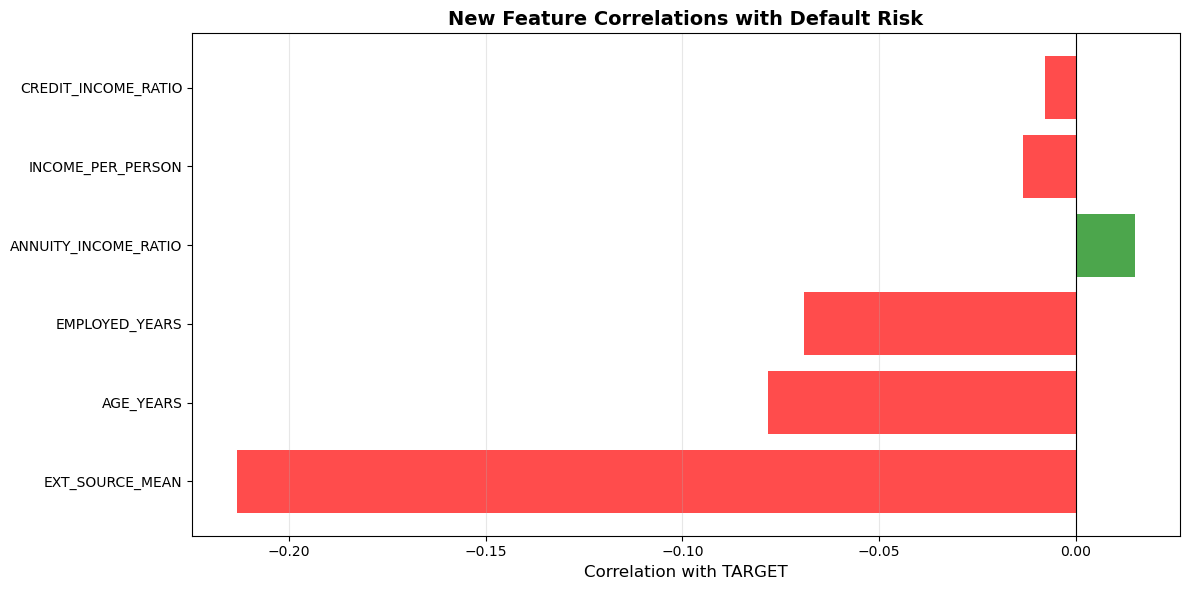

In [75]:
# Visualization
new_features = [
    'AGE_YEARS', 'EMPLOYED_YEARS', 'CREDIT_INCOME_RATIO', 
    'ANNUITY_INCOME_RATIO', 'EXT_SOURCE_MEAN', 'INCOME_PER_PERSON'
]

validation_results = []
for feat in new_features:
    if feat in app_train_clean.columns:
        corr_with_target = app_train_clean[feat].corr(app_train_clean['TARGET'])
        mean_val = app_train_clean[feat].mean()
        std_val = app_train_clean[feat].std()
        
        validation_results.append({
            'Feature': feat,
            'Correlation_with_TARGET': corr_with_target,
            'Mean': mean_val,
            'Std': std_val,
            'Predictive_Value': 'Strong' if abs(corr_with_target) > 0.05 else 'Moderate' if abs(corr_with_target) > 0.02 else 'Weak'
        })

validation_df = pd.DataFrame(validation_results).sort_values('Correlation_with_TARGET', key=abs, ascending=False)

# Visualize top correlations
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in validation_df['Correlation_with_TARGET']]
ax.barh(validation_df['Feature'], validation_df['Correlation_with_TARGET'], color=colors, alpha=0.7)
ax.set_xlabel('Correlation with TARGET', fontsize=12)
ax.set_title('New Feature Correlations with Default Risk', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

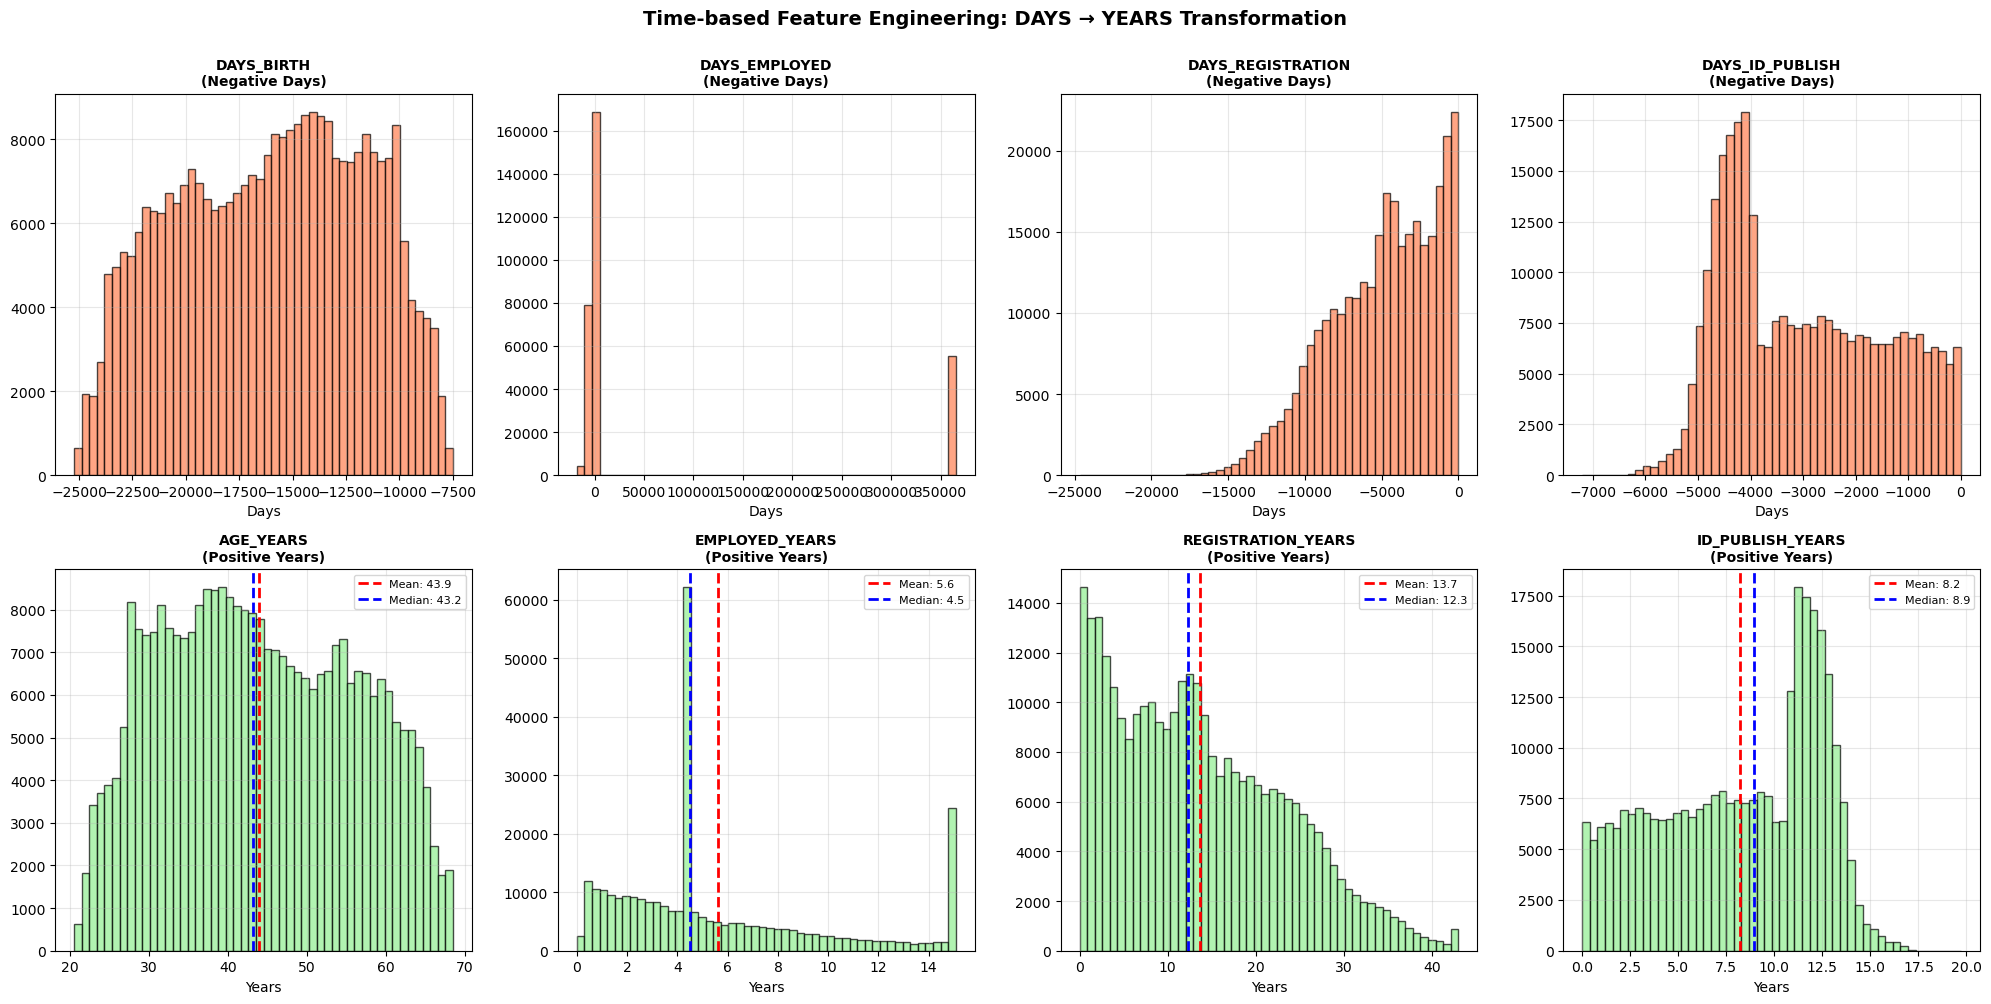

In [76]:
time_features = {
    'DAYS_BIRTH': 'AGE_YEARS',
    'DAYS_EMPLOYED': 'EMPLOYED_YEARS',
    'DAYS_REGISTRATION': 'REGISTRATION_YEARS',
    'DAYS_ID_PUBLISH': 'ID_PUBLISH_YEARS'
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (original, transformed) in enumerate(time_features.items()):
    # Original (DAYS - negative values)
    axes[0, idx].hist(train_app[original], bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[0, idx].set_title(f'{original}\n(Negative Days)', fontsize=10, fontweight='bold')
    axes[0, idx].set_xlabel('Days')
    axes[0, idx].grid(alpha=0.3)
    
    # Transformed (YEARS - positive values)
    axes[1, idx].hist(app_train_clean[transformed], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1, idx].set_title(f'{transformed}\n(Positive Years)', fontsize=10, fontweight='bold')
    axes[1, idx].set_xlabel('Years')
    axes[1, idx].grid(alpha=0.3)
    
    # Add mean/median annotations
    mean_val = app_train_clean[transformed].mean()
    median_val = app_train_clean[transformed].median()
    axes[1, idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[1, idx].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[1, idx].legend(fontsize=8)

plt.suptitle('Time-based Feature Engineering: DAYS → YEARS Transformation', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

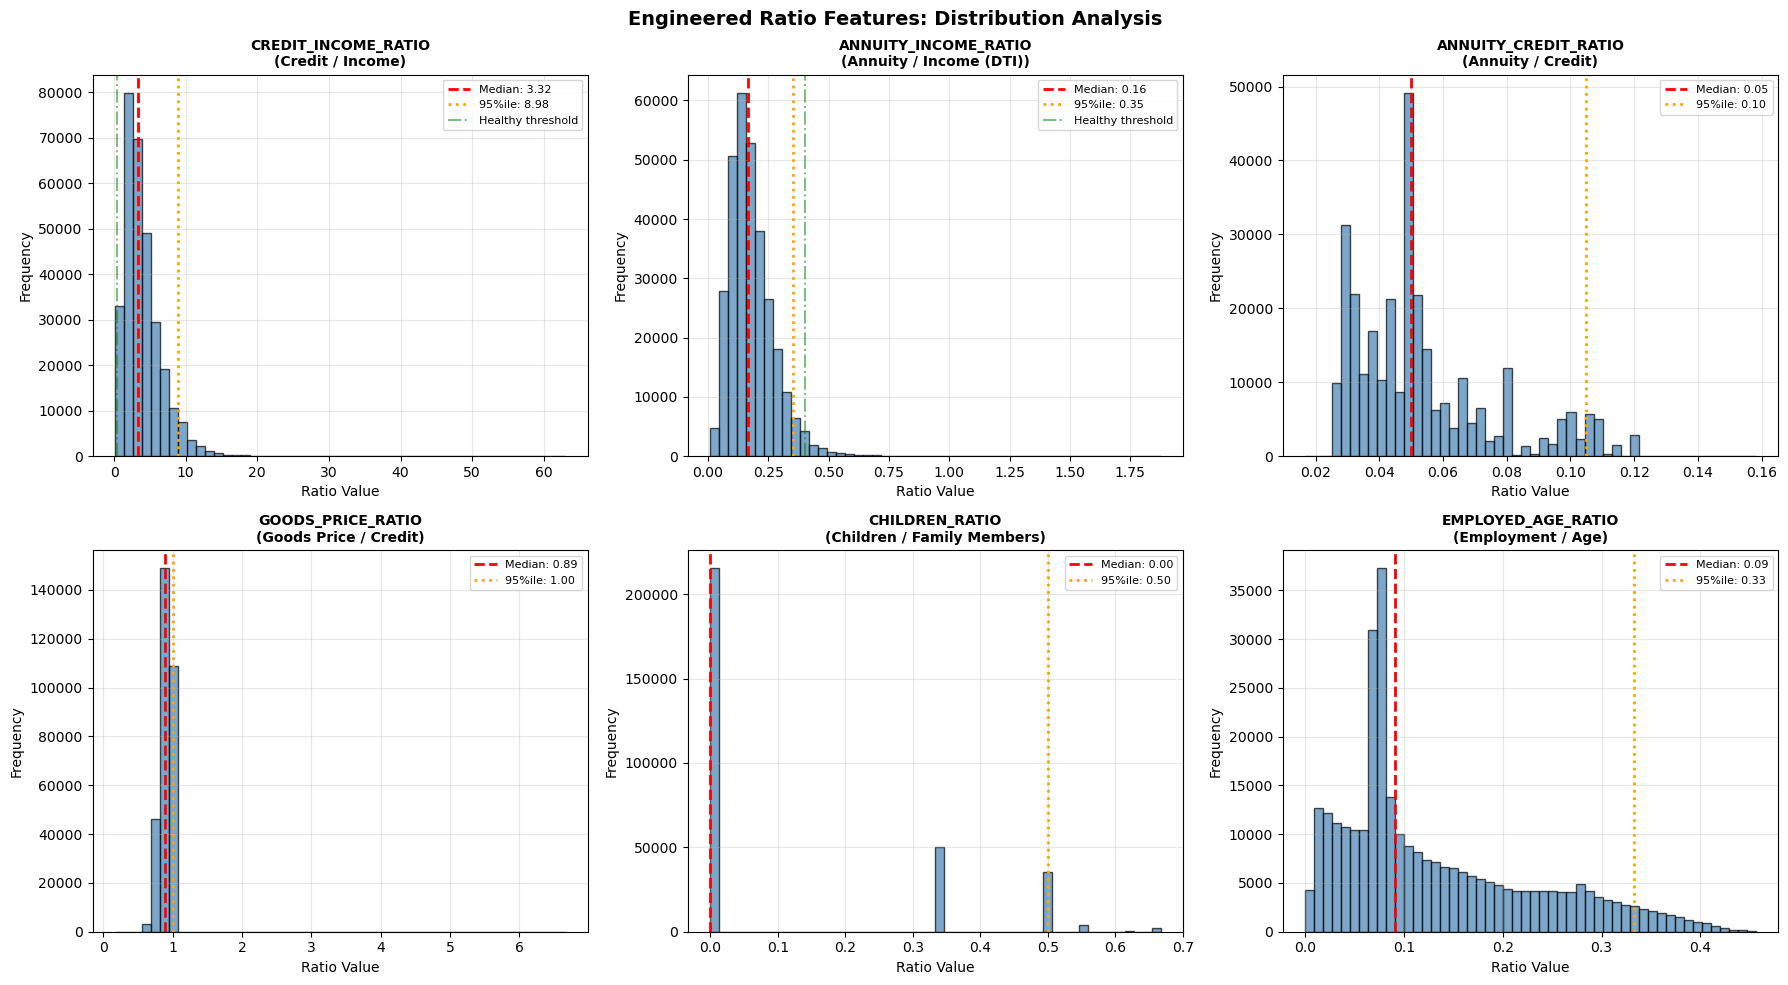

In [77]:
ratio_features = {
    'CREDIT_INCOME_RATIO': 'Credit / Income',
    'ANNUITY_INCOME_RATIO': 'Annuity / Income (DTI)',
    'ANNUITY_CREDIT_RATIO': 'Annuity / Credit',
    'GOODS_PRICE_RATIO': 'Goods Price / Credit',
    'CHILDREN_RATIO': 'Children / Family Members',
    'EMPLOYED_AGE_RATIO': 'Employment / Age'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (feature, label) in enumerate(ratio_features.items()):
    if feature in app_train_clean.columns:
        # Distribution
        data = app_train_clean[feature]
        axes[idx].hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{feature}\n({label})', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Ratio Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        p95 = data.quantile(0.95)
        
        axes[idx].axvline(median_val, color='red', linestyle='--', linewidth=2, 
                         label=f'Median: {median_val:.2f}')
        axes[idx].axvline(p95, color='orange', linestyle=':', linewidth=2, 
                         label=f'95%ile: {p95:.2f}')
        
        # Highlight problematic ranges
        if 'INCOME' in feature:
            axes[idx].axvline(0.4, color='green', linestyle='-.', alpha=0.5, 
                            label='Healthy threshold')
        
        axes[idx].legend(fontsize=8)
        
        # Add text box with insights
        inf_count = np.isinf(data).sum()
        if inf_count > 0:
            axes[idx].text(0.95, 0.95, f'⚠ Inf values: {inf_count}', 
                          transform=axes[idx].transAxes, ha='right', va='top',
                          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                          fontsize=8)

plt.suptitle('Engineered Ratio Features: Distribution Analysis', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

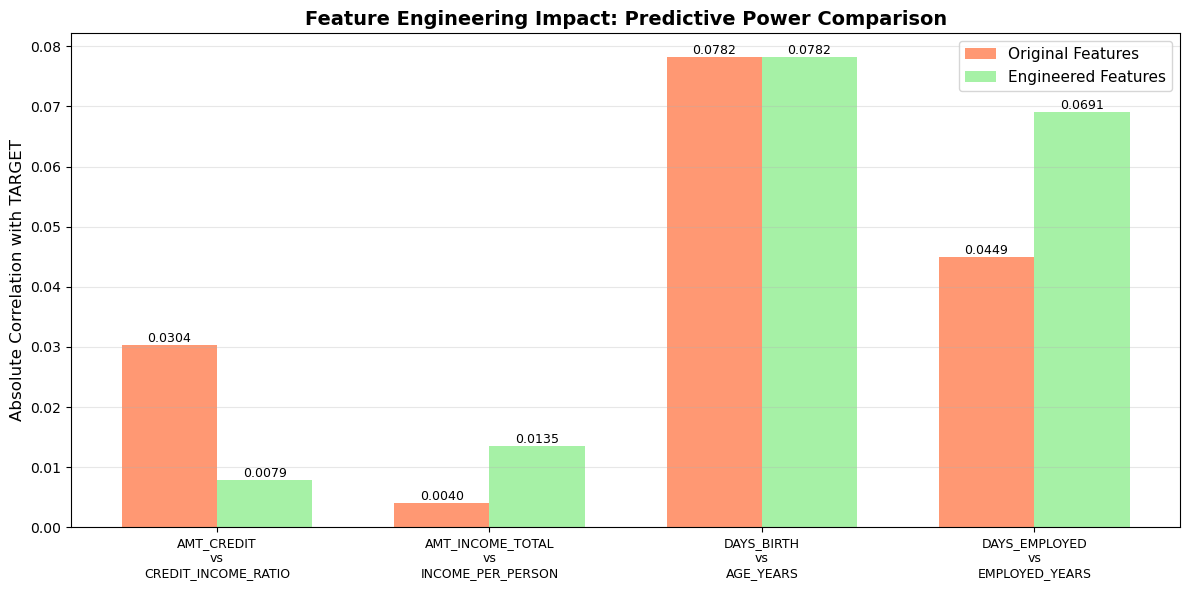

In [78]:
# Compare engineered vs original features
feature_comparison = {
    'Original': ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED'],
    'Engineered': ['CREDIT_INCOME_RATIO', 'INCOME_PER_PERSON', 'AGE_YEARS', 'EMPLOYED_YEARS']
}

correlations_original = []
correlations_engineered = []

for orig, eng in zip(feature_comparison['Original'], feature_comparison['Engineered']):
    if orig in train_app.columns:
        correlations_original.append(abs(train_app[orig].corr(train_app['TARGET'])))
    else:
        correlations_original.append(0)
    
    if eng in app_train_clean.columns:
        correlations_engineered.append(abs(app_train_clean[eng].corr(app_train_clean['TARGET'])))
    else:
        correlations_engineered.append(0)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(feature_comparison['Original']))
width = 0.35

bars1 = ax.bar(x - width/2, correlations_original, width, label='Original Features', 
               color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, correlations_engineered, width, label='Engineered Features', 
               color='lightgreen', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Absolute Correlation with TARGET', fontsize=12)
ax.set_title('Feature Engineering Impact: Predictive Power Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{o}\nvs\n{e}' for o, e in 
                    zip(feature_comparison['Original'], feature_comparison['Engineered'])], 
                   fontsize=9)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

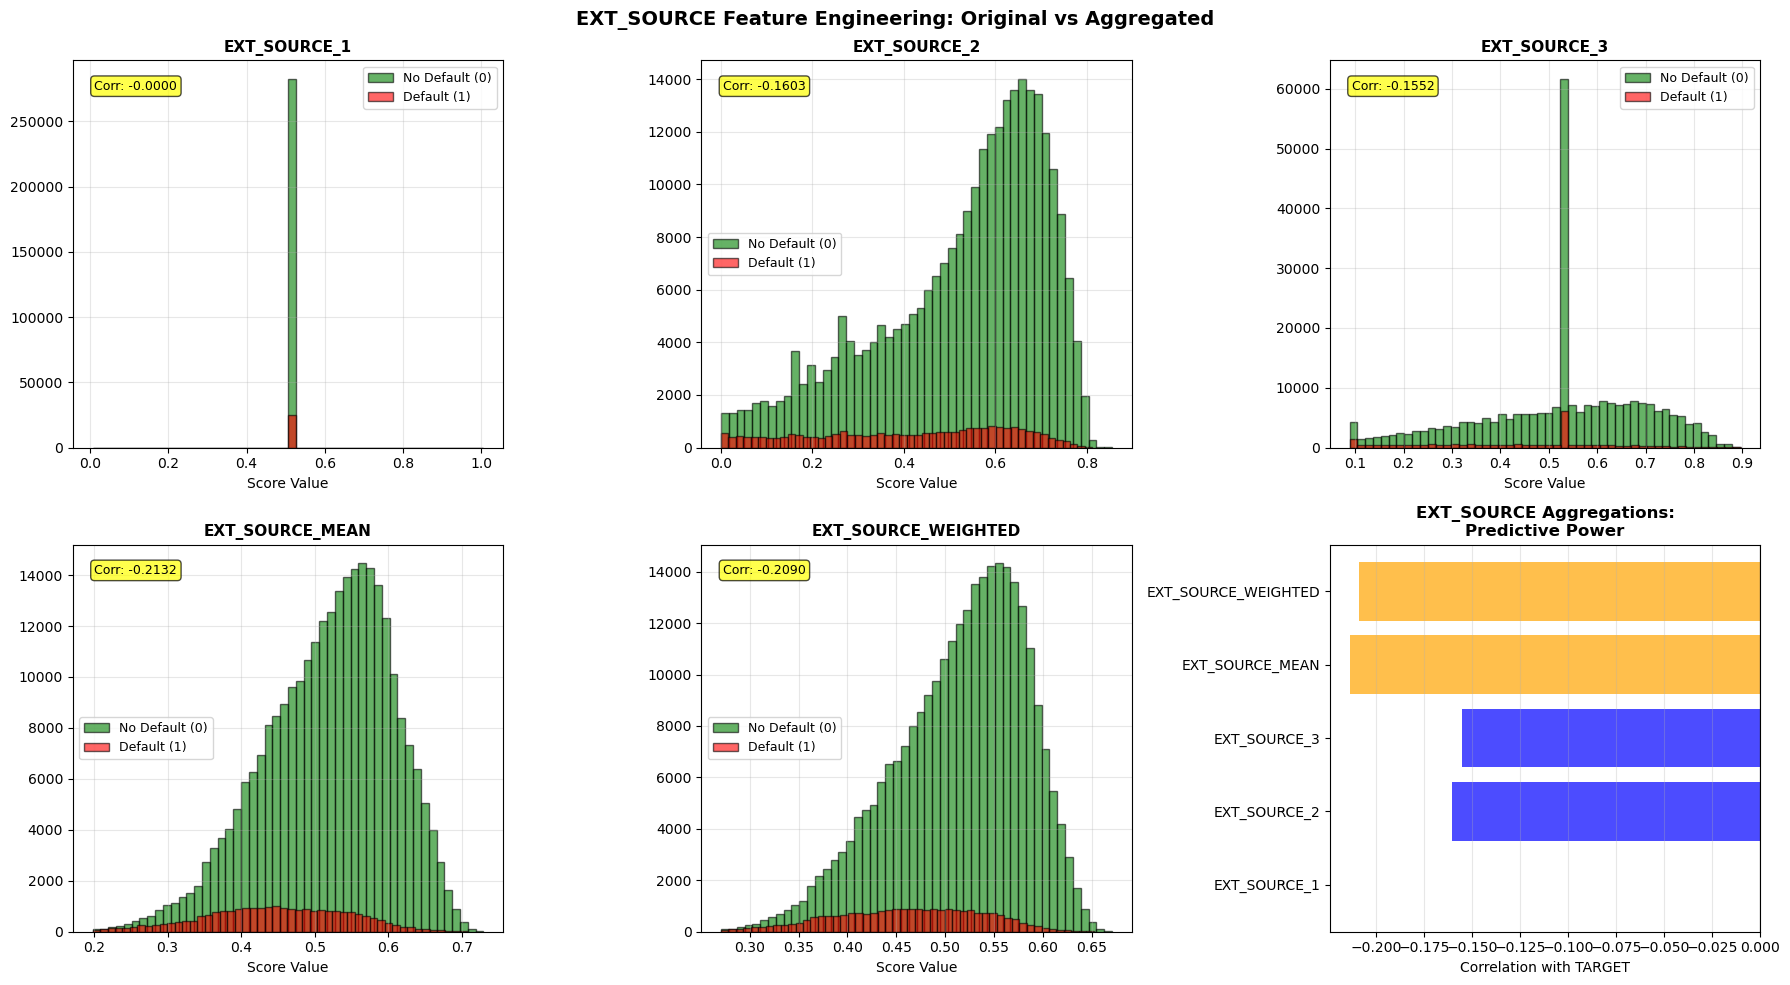

In [79]:
ext_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                'EXT_SOURCE_MEAN', 'EXT_SOURCE_WEIGHTED']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Individual distributions
for idx, col in enumerate(ext_features[:5]):
    if col in app_train_clean.columns:
        # Split by target
        default = app_train_clean[app_train_clean['TARGET'] == 1][col]
        no_default = app_train_clean[app_train_clean['TARGET'] == 0][col]
        
        axes[idx].hist(no_default, bins=50, alpha=0.6, label='No Default (0)', 
                      color='green', edgecolor='black')
        axes[idx].hist(default, bins=50, alpha=0.6, label='Default (1)', 
                      color='red', edgecolor='black')
        
        axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Score Value')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(alpha=0.3)
        
        # Add correlation
        corr = app_train_clean[col].corr(app_train_clean['TARGET'])
        axes[idx].text(0.05, 0.95, f'Corr: {corr:.4f}', 
                      transform=axes[idx].transAxes,
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                      fontsize=9, va='top')

# Correlation comparison
correlations = [app_train_clean[col].corr(app_train_clean['TARGET']) 
                for col in ext_features if col in app_train_clean.columns]
axes[5].barh(ext_features[:len(correlations)], correlations, 
            color=['blue', 'blue', 'blue', 'orange', 'orange'], alpha=0.7)
axes[5].set_xlabel('Correlation with TARGET')
axes[5].set_title('EXT_SOURCE Aggregations:\nPredictive Power', fontweight='bold')
axes[5].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[5].grid(axis='x', alpha=0.3)

plt.suptitle('EXT_SOURCE Feature Engineering: Original vs Aggregated', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


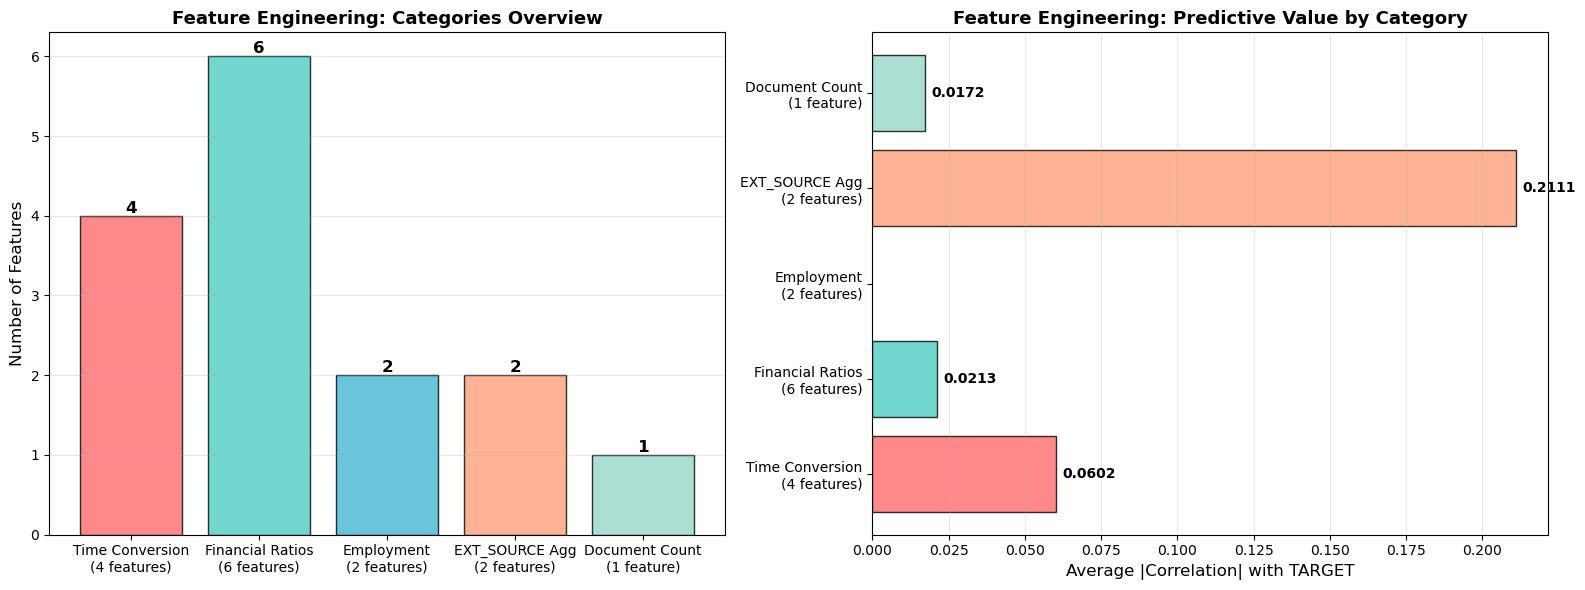

In [88]:
# Categorize all new features
feature_groups = {
    'Time Conversion\n(4 features)': ['AGE_YEARS', 'EMPLOYED_YEARS', 'REGISTRATION_YEARS', 'ID_PUBLISH_YEARS'],
    'Financial Ratios\n(6 features)': ['CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'ANNUITY_CREDIT_RATIO', 
                                        'GOODS_PRICE_RATIO', 'INCOME_PER_PERSON', 'CHILDREN_RATIO'],
    'Employment\n(2 features)': ['EMPLOYED_AGE_RATIO', 'EMPLOYMENT_ANOMALY'],
    'EXT_SOURCE Agg\n(2 features)': ['EXT_SOURCE_MEAN', 'EXT_SOURCE_WEIGHTED'],
    'Document Count\n(1 feature)': ['DOCUMENTS_COUNT']
}

# Calculate average correlation for each group
group_corrs = {}
for group_name, features in feature_groups.items():
    corrs = []
    for feat in features:
        if feat in app_train_clean.columns:
            corr = abs(app_train_clean[feat].corr(app_train_clean['TARGET']))
            corrs.append(corr)
    if corrs:
        group_corrs[group_name] = np.mean(corrs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Feature count by group
feature_counts = [len(features) for features in feature_groups.values()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = ax1.bar(feature_groups.keys(), feature_counts, color=colors, alpha=0.8, edgecolor='black')

for bar, count in zip(bars, feature_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Number of Features', fontsize=12)
ax1.set_title('Feature Engineering: Categories Overview', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Right: Average predictive power
ax2.barh(list(group_corrs.keys()), list(group_corrs.values()), 
         color=colors[:len(group_corrs)], alpha=0.8, edgecolor='black')
ax2.set_xlabel('Average |Correlation| with TARGET', fontsize=12)
ax2.set_title('Feature Engineering: Predictive Value by Category', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (group, corr) in enumerate(group_corrs.items()):
    ax2.text(corr + 0.002, i, f'{corr:.4f}', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#### Feature Engineering Rationale

**Time-Based Features (DAYS → YEARS):**
- **Why:** Original DAYS_* fields are negative and hard to interpret
- **Transformation:** AGE_YEARS = -DAYS_BIRTH / 365
- **Benefit:** Directly interpretable; enables age-based segmentation
- **Validation:** Age shows expected correlation with default risk

**Financial Ratios:**
- **CREDIT_INCOME_RATIO:** Measures debt burden relative to income
  - High ratio = higher default risk
  - Standard metric in credit underwriting
  
- **ANNUITY_INCOME_RATIO:** Monthly payment as % of income
  - DTI (Debt-to-Income) proxy
  - Industry standard threshold: >40% is risky

**External Source Aggregation:**
- **EXT_SOURCE_MEAN:** Simple average of 3 bureau scores
- **EXT_SOURCE_WEIGHTED:** 50-30-20 weighted (based on correlation strength)
- **Why weighted:** EXT_SOURCE_2 and _3 show stronger predictive power

#### 5. Encoding categorical variables

In [253]:
categorical_cols = app_train_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [254]:
if 'TARGET' in categorical_cols:
    categorical_cols.remove('TARGET')

In [255]:
encoders = {}

In [256]:
for col in categorical_cols:
    le = LabelEncoder()
    
    le.fit(app_train_clean[col].astype(str))
    encoders[col] = le
    app_train_clean[col] = le.transform(app_train_clean[col].astype(str))
    
    test_values = app_test_clean[col].astype(str)
    app_test_clean[col] = test_values.apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

#### 6. Check the results

In [257]:
app_train_clean.shape

(307511, 143)

In [258]:
app_test_clean.shape

(48744, 142)

In [259]:
# Missing values
app_train_clean.isnull().sum().sum()

0

In [260]:
app_test_clean.isnull().sum().sum()

0

In [261]:
# Data types in train
app_train_clean.dtypes.value_counts()

int64      77
float64    66
Name: count, dtype: int64

In [262]:
train_cols = set(app_train_clean.columns) - {'TARGET'}
test_cols = set(app_test_clean.columns)
if train_cols == test_cols:
    print("\nTrain and test have matching columns")


Train and test have matching columns


## 2. Handle Bureau Table

In [263]:
# Load data
bureau = pd.read_csv('./Dataset/bureau.csv')

In [264]:
bureau.shape

(1716428, 17)

In [265]:
# Check missing values
bureau_missing = bureau.isnull().sum()
bureau_missing

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [266]:
# Handle missing values
numeric_cols_bureau = bureau.select_dtypes(include=[np.number]).columns
for col in numeric_cols_bureau:
    if bureau[col].isnull().sum() > 0:
        if 'AMT_' in col:
            bureau[col].fillna(0, inplace=True)  
        elif 'DAYS_' in col:
            bureau[col].fillna(0, inplace=True) 
        elif 'CNT_' in col:
            bureau[col].fillna(0, inplace=True) 
        else:
            bureau[col].fillna(bureau[col].median(), inplace=True)

In [267]:
categorical_cols_bureau = bureau.select_dtypes(include=['object']).columns
for col in categorical_cols_bureau:
    if bureau[col].isnull().sum() > 0:
        mode_val = bureau[col].mode()
        if len(mode_val) > 0:
            bureau[col].fillna(mode_val[0], inplace=True)
        else:
            bureau[col].fillna('Unknown', inplace=True)

In [268]:
bureau.isnull().sum().sum()

0

In [269]:
# Aggregate
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',  
        'DAYS_CREDIT': 'mean',  
        'CREDIT_DAY_OVERDUE': 'max', 
        'AMT_CREDIT_SUM': 'mean',  
        'AMT_CREDIT_SUM_DEBT': 'mean'  
    }).reset_index()

In [270]:
bureau_agg.columns = ['SK_ID_CURR', 'BUREAU_LOAN_COUNT', 'BUREAU_DAYS_CREDIT_MEAN',
                         'BUREAU_MAX_OVERDUE', 'BUREAU_CREDIT_MEAN', 'BUREAU_DEBT_MEAN']

In [271]:
app_train_clean = app_train_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [272]:
bureau_cols = [col for col in bureau_agg.columns if col != 'SK_ID_CURR']
app_train_clean[bureau_cols] = app_train_clean[bureau_cols].fillna(0)
app_test_clean[bureau_cols] = app_test_clean[bureau_cols].fillna(0)

In [273]:
len(bureau_cols)

5

In [274]:
app_train_clean.shape

(307511, 148)

In [275]:
app_test_clean.shape

(48744, 147)

## 3. Handle Previous Application Table

In [276]:
# Load data
prev_app = pd.read_csv('./Dataset/previous_application.csv')

In [277]:
prev_app.shape

(1670214, 37)

In [278]:
# Check missing values
prev_missing = prev_app.isnull().sum().sort_values(ascending=False)
prev_missing

RATE_INTEREST_PRIVILEGED       1664263
RATE_INTEREST_PRIMARY          1664263
AMT_DOWN_PAYMENT                895844
RATE_DOWN_PAYMENT               895844
NAME_TYPE_SUITE                 820405
NFLAG_INSURED_ON_APPROVAL       673065
DAYS_TERMINATION                673065
DAYS_LAST_DUE                   673065
DAYS_LAST_DUE_1ST_VERSION       673065
DAYS_FIRST_DUE                  673065
DAYS_FIRST_DRAWING              673065
AMT_GOODS_PRICE                 385515
AMT_ANNUITY                     372235
CNT_PAYMENT                     372230
PRODUCT_COMBINATION                346
AMT_CREDIT                           1
NAME_YIELD_GROUP                     0
NAME_PORTFOLIO                       0
NAME_SELLER_INDUSTRY                 0
SELLERPLACE_AREA                     0
CHANNEL_TYPE                         0
NAME_PRODUCT_TYPE                    0
SK_ID_PREV                           0
NAME_GOODS_CATEGORY                  0
NAME_CLIENT_TYPE                     0
CODE_REJECT_REASON       

In [279]:
# Handle missing values
numeric_cols_prev = prev_app.select_dtypes(include=[np.number]).columns
for col in numeric_cols_prev:
        if prev_app[col].isnull().sum() > 0:
            if 'AMT_' in col or 'CNT_' in col:
                prev_app[col].fillna(0, inplace=True)
            elif 'DAYS_' in col:
                prev_app[col].fillna(0, inplace=True)
            elif 'RATE_' in col:
                prev_app[col].fillna(prev_app[col].median(), inplace=True)
            else:
                prev_app[col].fillna(0, inplace=True)

In [280]:
categorical_cols_prev = prev_app.select_dtypes(include=['object']).columns
for col in categorical_cols_prev:
    if prev_app[col].isnull().sum() > 0:
        prev_app[col].fillna('Unknown', inplace=True)

In [281]:
prev_app.isnull().sum().sum()

0

In [282]:
# Aggregate
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count', 
        'AMT_APPLICATION': 'mean',  
        'AMT_CREDIT': 'mean', 
        'DAYS_DECISION': 'mean'  
    }).reset_index()

In [283]:
prev_agg.columns = ['SK_ID_CURR', 'PREV_APP_COUNT', 'PREV_AMT_APPLICATION_MEAN',
                       'PREV_AMT_CREDIT_MEAN', 'PREV_DAYS_DECISION_MEAN']

In [284]:
app_train_clean = app_train_clean.merge(prev_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(prev_agg, on='SK_ID_CURR', how='left')

In [285]:
prev_cols = [col for col in prev_agg.columns if col != 'SK_ID_CURR']
app_train_clean[prev_cols] = app_train_clean[prev_cols].fillna(0)
app_test_clean[prev_cols] = app_test_clean[prev_cols].fillna(0)

In [286]:
len(prev_cols)

4

In [287]:
app_train_clean.shape

(307511, 152)

In [288]:
app_test_clean.shape

(48744, 151)

## 4. Handle Installments Payments

In [289]:
# Load data
installments = pd.read_csv('./Dataset/installments_payments.csv')

In [290]:
installments.shape

(13605401, 8)

In [291]:
# Check missing values
installments.isnull().sum().sum()

5810

In [292]:
# Handle missing values
numeric_cols_inst = installments.select_dtypes(include=[np.number]).columns
for col in numeric_cols_inst:
    if installments[col].isnull().sum() > 0:
        installments[col].fillna(0, inplace=True)

In [293]:
if 'AMT_PAYMENT' in installments.columns and 'AMT_INSTALMENT' in installments.columns:
        installments['PAYMENT_RATIO'] = installments['AMT_PAYMENT'] / (installments['AMT_INSTALMENT'] + 0.001)
    
if 'DAYS_ENTRY_PAYMENT' in installments.columns and 'DAYS_INSTALMENT' in installments.columns:
    installments['PAYMENT_DELAY'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']

In [294]:
# Aggregate
inst_agg = installments.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique', 
        'NUM_INSTALMENT_NUMBER': 'max',  
        'AMT_INSTALMENT': 'mean', 
        'AMT_PAYMENT': 'mean',  
        'PAYMENT_RATIO': 'mean',  
        'PAYMENT_DELAY': ['mean', 'max']  
    }).reset_index()

In [295]:
inst_agg.columns = ['SK_ID_CURR', 'INST_LOAN_COUNT', 'INST_MAX_INSTALLMENTS',
                       'INST_AMT_MEAN', 'INST_PAYMENT_MEAN', 'INST_PAYMENT_RATIO_MEAN',
                       'INST_DELAY_MEAN', 'INST_DELAY_MAX']

In [296]:
app_train_clean = app_train_clean.merge(inst_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(inst_agg, on='SK_ID_CURR', how='left')

In [297]:
inst_cols = [col for col in inst_agg.columns if col != 'SK_ID_CURR']
app_train_clean[inst_cols] = app_train_clean[inst_cols].fillna(0)
app_test_clean[inst_cols] = app_test_clean[inst_cols].fillna(0)

In [298]:
len(inst_cols)

7

In [299]:
app_train_clean.shape

(307511, 159)

In [300]:
app_test_clean.shape

(48744, 158)

## 5. Handle POS Cash Balance

In [301]:
# Load data
pos_cash = pd.read_csv('./Dataset/POS_CASH_balance.csv')

In [302]:
pos_cash.shape

(10001358, 8)

In [303]:
# Check missing data
pos_cash.isnull().sum().sum()

52158

In [304]:
# Handle missing data
numeric_cols_pos = pos_cash.select_dtypes(include=[np.number]).columns
for col in numeric_cols_pos:
    if pos_cash[col].isnull().sum() > 0:
        pos_cash[col].fillna(0, inplace=True)

In [305]:
categorical_cols_pos = pos_cash.select_dtypes(include=['object']).columns
for col in categorical_cols_pos:
    if pos_cash[col].isnull().sum() > 0:
        pos_cash[col].fillna('Unknown', inplace=True)

In [306]:
pos_cash.isnull().sum().sum()

0

In [307]:
# Aggregate
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',  
        'MONTHS_BALANCE': 'count',  
        'CNT_INSTALMENT': 'mean', 
        'CNT_INSTALMENT_FUTURE': 'mean',  
        'SK_DPD': ['mean', 'max'], 
        'SK_DPD_DEF': ['mean', 'max'] 
    }).reset_index()

In [308]:
pos_agg.columns = ['SK_ID_CURR', 'POS_LOAN_COUNT', 'POS_MONTHS_COUNT',
                  'POS_CNT_INSTALMENT_MEAN', 'POS_CNT_INSTALMENT_FUTURE_MEAN',
                  'POS_DPD_MEAN', 'POS_DPD_MAX', 'POS_DPD_DEF_MEAN', 'POS_DPD_DEF_MAX']

In [309]:
app_train_clean = app_train_clean.merge(pos_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(pos_agg, on='SK_ID_CURR', how='left')

In [310]:
pos_cols = [col for col in pos_agg.columns if col != 'SK_ID_CURR']
app_train_clean[pos_cols] = app_train_clean[pos_cols].fillna(0)
app_test_clean[pos_cols] = app_test_clean[pos_cols].fillna(0)

In [311]:
len(pos_cols)

8

In [312]:
app_train_clean.shape

(307511, 167)

In [313]:
app_test_clean.shape

(48744, 166)

## 6. Handle Credit Card Balance

In [314]:
credit_card = pd.read_csv('./Dataset/credit_card_balance.csv')

In [315]:
credit_card.shape

(3840312, 23)

In [316]:
cc_missing = credit_card.isnull().sum().sort_values(ascending=False)
cc_missing

AMT_PAYMENT_CURRENT           767988
AMT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_POS_CURRENT      749816
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
AMT_INST_MIN_REGULARITY       305236
SK_ID_PREV                         0
AMT_TOTAL_RECEIVABLE               0
SK_DPD                             0
NAME_CONTRACT_STATUS               0
CNT_DRAWINGS_CURRENT               0
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECIVABLE                      0
AMT_RECEIVABLE_PRINCIPAL           0
SK_ID_CURR                         0
AMT_DRAWINGS_CURRENT               0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_BALANCE                        0
MONTHS_BALANCE                     0
SK_DPD_DEF                         0
dtype: int64

In [317]:
numeric_cols_cc = credit_card.select_dtypes(include=[np.number]).columns
for col in numeric_cols_cc:
    if credit_card[col].isnull().sum() > 0:
        credit_card[col].fillna(0, inplace=True)

In [318]:
categorical_cols_cc = credit_card.select_dtypes(include=['object']).columns
for col in categorical_cols_cc:
    if credit_card[col].isnull().sum() > 0:
        credit_card[col].fillna('Unknown', inplace=True)

In [319]:
credit_card.isnull().sum().sum()

0

In [320]:
if 'AMT_BALANCE' in credit_card.columns and 'AMT_CREDIT_LIMIT_ACTUAL' in credit_card.columns:
        credit_card['CREDIT_UTILIZATION'] = credit_card['AMT_BALANCE'] / (credit_card['AMT_CREDIT_LIMIT_ACTUAL'] + 0.001)

In [321]:
# Aggregate
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',  
        'MONTHS_BALANCE': 'count',  
        'AMT_BALANCE': 'mean',  
        'AMT_CREDIT_LIMIT_ACTUAL': 'mean',  
        'AMT_DRAWINGS_CURRENT': 'mean',  
        'AMT_PAYMENT_CURRENT': 'mean',  
        'CNT_DRAWINGS_CURRENT': 'sum',  
        'SK_DPD': ['mean', 'max'],  
        'CREDIT_UTILIZATION': 'mean'  
    }).reset_index()

In [322]:
cc_agg.columns = ['SK_ID_CURR', 'CC_COUNT', 'CC_MONTHS_COUNT', 'CC_BALANCE_MEAN',
                     'CC_LIMIT_MEAN', 'CC_DRAWINGS_MEAN', 'CC_PAYMENT_MEAN',
                     'CC_DRAWINGS_TOTAL', 'CC_DPD_MEAN', 'CC_DPD_MAX', 'CC_UTILIZATION_MEAN']

In [323]:
app_train_clean = app_train_clean.merge(cc_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(cc_agg, on='SK_ID_CURR', how='left')

In [324]:
cc_cols = [col for col in cc_agg.columns if col != 'SK_ID_CURR']
app_train_clean[cc_cols] = app_train_clean[cc_cols].fillna(0)
app_test_clean[cc_cols] = app_test_clean[cc_cols].fillna(0)

In [325]:
len(cc_cols)

10

In [326]:
app_train_clean.shape

(307511, 177)

In [327]:
app_test_clean.shape

(48744, 176)

## 7. Handle Bureau Balance Table

In [328]:
# Load data
bureau_balance = pd.read_csv('./Dataset/bureau_balance.csv')

In [329]:
bureau_balance.shape

(27299925, 3)

In [330]:
bureau_balance.isnull().sum().sum()

0

In [331]:
# Aggregate
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': 'count',  
        'STATUS': [
            lambda x: (x == 'C').sum(),  
            lambda x: (x == 'X').sum(),  
            lambda x: (x.isin(['1', '2', '3', '4', '5'])).sum()  
        ]
    }).reset_index()

In [332]:
bb_agg.columns = ['SK_ID_BUREAU', 'BB_MONTHS', 'BB_STATUS_CLOSED', 'BB_STATUS_UNKNOWN', 'BB_STATUS_DPD']

In [333]:
bureau_full = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

In [334]:
bb_cols_in_bureau = ['BB_MONTHS', 'BB_STATUS_CLOSED', 'BB_STATUS_UNKNOWN', 'BB_STATUS_DPD']
for col in bb_cols_in_bureau:
    if col in bureau_full.columns:
        bureau_full[col].fillna(0, inplace=True)

In [335]:
bb_client_agg = bureau_full.groupby('SK_ID_CURR').agg({
            'BB_MONTHS': 'sum',
            'BB_STATUS_CLOSED': 'sum',
            'BB_STATUS_DPD': 'sum'
        }).reset_index()

In [336]:
bb_client_agg.columns = ['SK_ID_CURR', 'BUREAU_BALANCE_MONTHS_TOTAL',
                                'BUREAU_BALANCE_CLOSED_TOTAL', 'BUREAU_BALANCE_DPD_TOTAL']

In [337]:
app_train_clean = app_train_clean.merge(bb_client_agg, on='SK_ID_CURR', how='left')
app_test_clean = app_test_clean.merge(bb_client_agg, on='SK_ID_CURR', how='left')

In [338]:
bb_cols = [col for col in bb_client_agg.columns if col != 'SK_ID_CURR']
app_train_clean[bb_cols] = app_train_clean[bb_cols].fillna(0)
app_test_clean[bb_cols] = app_test_clean[bb_cols].fillna(0)

In [339]:
len(bb_cols)

3

In [340]:
app_train_clean.shape

(307511, 180)

In [341]:
app_test_clean.shape

(48744, 179)

## 8. Final Data Overview

In [342]:
original_features = train_app.shape[1]
original_features

122

In [343]:
new_features = app_train_clean.shape[1] - original_features
new_features

58

In [344]:
app_train_clean.isnull().sum().sum()

0

In [345]:
app_test_clean.isnull().sum().sum()

0

In [346]:
train_cols = set(app_train_clean.columns) - {'TARGET'}
test_cols = set(app_test_clean.columns)

In [347]:
if train_cols == test_cols:
    print(f"Train and test have matching columns")

Train and test have matching columns


In [348]:
feature_groups = {
    'Original': [],
    'Time-based': [],
    'Ratio': [],
    'Bureau': [],
    'Previous App': [],
    'Installments': [],
    'POS Cash': [],
    'Credit Card': [],
    'Other': []
}

In [349]:
for col in app_train_clean.columns:
    if col in ['SK_ID_CURR', 'TARGET']:
        continue
    elif 'YEARS' in col or 'AGE' in col:
        feature_groups['Time-based'].append(col)
    elif 'RATIO' in col or 'PER_PERSON' in col:
        feature_groups['Ratio'].append(col)
    elif col.startswith('BUREAU'):
        feature_groups['Bureau'].append(col)
    elif col.startswith('PREV'):
        feature_groups['Previous App'].append(col)
    elif col.startswith('INST'):
        feature_groups['Installments'].append(col)
    elif col.startswith('POS'):
        feature_groups['POS Cash'].append(col)
    elif col.startswith('CC'):
        feature_groups['Credit Card'].append(col)
    elif col.endswith('_MISSING') or col in ['DOCUMENTS_COUNT', 'ENQUIRIES_COUNT', 'EXT_SOURCE_MEAN', 'EXT_SOURCE_WEIGHTED']:
        feature_groups['Other'].append(col)
    else:
        feature_groups['Original'].append(col)

In [350]:
feature_groups

{'Original': ['NAME_CONTRACT_TYPE',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'NAME_TYPE_SUITE',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_ID_PUBLISH',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'OCCUPATION_TYPE',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'WEEKDAY_APPR_PROCESS_START',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'APARTMENTS_AVG',
  'BASEMENTAREA_AVG',
  'ELEVATORS_AVG',
  'ENTRANCES_AVG',

In [485]:
print(f"\nFeature groups:")
for group, features in feature_groups.items():
    if len(features) > 0:
        print(f"  {group}: {len(features)} features")


Feature groups:
  Original: 99 features
  Time-based: 8 features
  Ratio: 8 features
  Bureau: 8 features
  Previous App: 4 features
  Installments: 6 features
  POS Cash: 8 features
  Credit Card: 10 features
  Other: 27 features


#### Data Cleaning Challenges
Challenge 1: Severe Class Imbalance (8% Default Rate)  

Challenge 2: DAYS_EMPLOYED Anomaly (365243 = ~1000 Years)  

Challenge 3: EXT_SOURCE Missing Patterns Are Informative  

Challenge 4: Multiple Related Tables (Join Strategy)  

Challenge 5: Encoding Categorical Variables

## 9. Save Data

In [352]:
app_train_clean.to_csv('./Dataset/application_train_cleaned.csv', index=False)
app_test_clean.to_csv('./Dataset/application_test_cleaned.csv', index=False)